# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [198]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy, draw_triplets_xy, get_dataset)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by config file
config_file = '../configs/tripgnn_med.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

FileNotFoundError: [Errno 2] File b'/global/cscratch1/sd/danieltm/ExaTrkX/triplet_results/checkpoints_med/agnn02/summaries_0.csv' does not exist: b'/global/cscratch1/sd/danieltm/ExaTrkX/triplet_results/checkpoints_med/agnn02/summaries_0.csv'

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/triplet_results/checkpoints_med')

In [33]:
config

{'output_dir': '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/triplet_results/checkpoints_med/agnn02',
 'trainer': {'name': 'gnn_sparse'},
 'data': {'name': 'hitgraphs_sparse',
  'input_dir': '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/triplet_data/hitgraphs_med/',
  'n_train': 1920,
  'n_valid': 80,
  'real_weight': 3.0,
  'batch_size': 4,
  'n_workers': 4},
 'model': {'name': 'tripgnn',
  'input_dim': 7,
  'hidden_dim': 64,
  'n_graph_iters': 3,
  'layer_norm': True,
  'loss_func': 'binary_cross_entropy_with_logits'},
 'optimizer': {'name': 'Adam',
  'learning_rate': 0.01,
  'lr_scaling': 'sqrt',
  'lr_warmup_epochs': 5,
  'lr_decay_schedule': [{'start_epoch': 10, 'end_epoch': 25, 'factor': 0.5},
   {'start_epoch': 25, 'end_epoch': 40, 'factor': 0.01},
   {'start_epoch': 40, 'end_epoch': 50, 'factor': 0.005},
   {'start_epoch': 50, 'end_epoch': 64, 'factor': 0.001}]},
 'training': {'n_epochs': 64},
 'n_ranks': 1,
 'input_dir': '/mnt/c/Users/Daniel/Dropbox/R

In [20]:
config['data']['input_dir']='/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/triplet_data/hitgraphs_med/'
config['output_dir'] = '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/triplet_results/checkpoints_med/agnn02'

In [21]:
summaries = load_summaries(config)
print('\nTraining summaries:')
summaries


Training summaries:


,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.01000,0.543906,5555.554894,170.790769,0,66.577327,0.937875,0.714012,1.714154
1,0.01000,0.399588,5802.526887,186.532917,1,65.983641,0.172344,0.936334,1.593416
2,0.01000,0.150020,5822.716031,189.231290,2,65.765237,0.136028,0.944074,1.593735
3,0.01000,0.138693,5835.690972,190.958241,3,65.665213,0.284043,0.849298,1.593498
4,0.01000,0.134838,5850.550570,192.258600,4,65.713242,0.137543,0.940164,1.593192
...,...,...,...,...,...,...,...,...,...
59,0.00001,0.095728,9054.677785,272.108777,59,66.047443,0.110819,0.951398,1.616252
60,0.00001,0.095778,9055.067878,272.117683,60,65.907556,0.110690,0.951453,1.703676
61,0.00001,0.095719,9055.404952,272.126195,61,65.846436,0.110788,0.951340,1.611871
62,0.00001,0.095650,9055.762635,272.135181,62,65.644478,0.111201,0.951213,1.611236


In [19]:
result_name = 'agnn02'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/triplet_data/hitgraphs_med',
          'n_train': 1920,
          'n_valid': 80,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 7,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 3,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.01,
               'lr_decay_schedule': [{'end_epoch': 25,
                                      'factor': 0.5,
                                      'start_epoch': 10},
                                     {'end_epoch': 40,
                                      'factor': 0.01,
                                      'start_epoch': 25},
                                     {'end_epoch': 50,
                                      'factor': 0.005,
               

FileNotFoundError: [Errno 2] File b'/global/cscratch1/sd/danieltm/ExaTrkX/triplet_results/checkpoints_med/agnn02/summaries_0.csv' does not exist: b'/global/cscratch1/sd/danieltm/ExaTrkX/triplet_results/checkpoints_med/agnn02/summaries_0.csv'

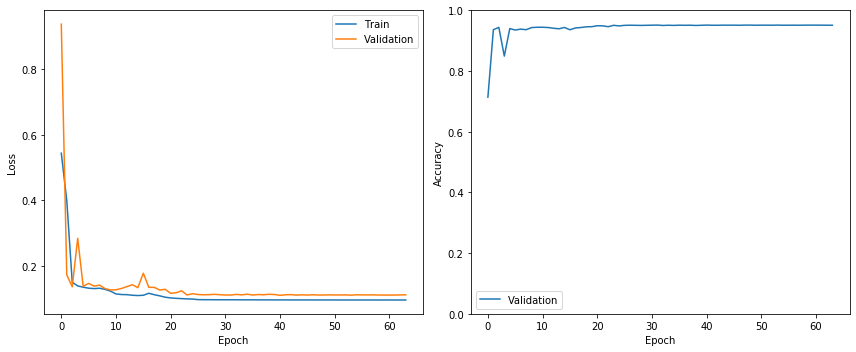

In [22]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

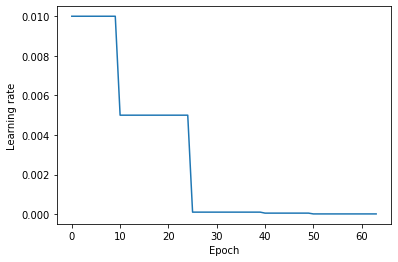

In [23]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [24]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
40,0.00005,0.09598,9034.433166,271.623412,40,65.859984,0.110001,0.951619,1.612672


In [34]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=142, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=213, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [42]:
# Load the test dataset
n_test = 16
test_loader = get_test_data_loader(config, n_test=n_test)

In [45]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 32.3 s, sys: 3.64 s, total: 36 s
Wall time: 31.9 s


In [46]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9513
Precision: 0.9394
Recall:    0.9964


In [13]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9620
Precision: 0.9646
Recall:    0.9828


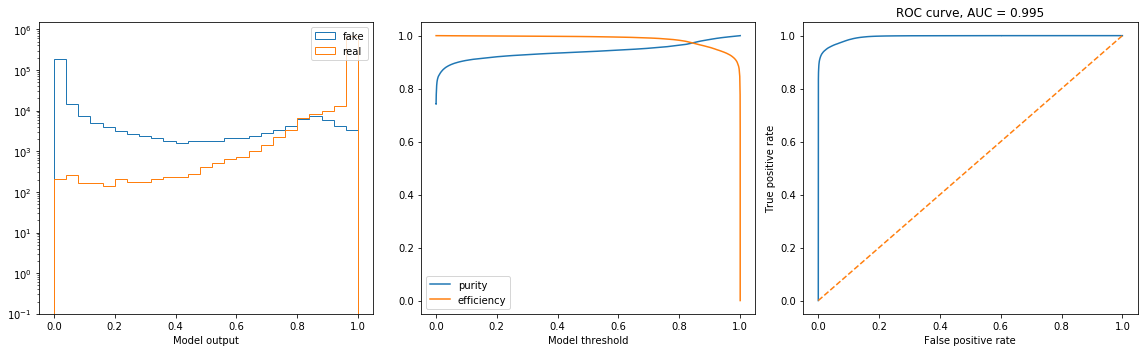

In [47]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [48]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000., 1000., np.pi / n_phi_sections, 1000., 1])

In [192]:
i=13
g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [182]:
x_o = np.concatenate([x[e[0,:]], x[e[1,:]], np.array([o]).T], axis=1)

In [184]:
x_o.shape

(39439, 15)

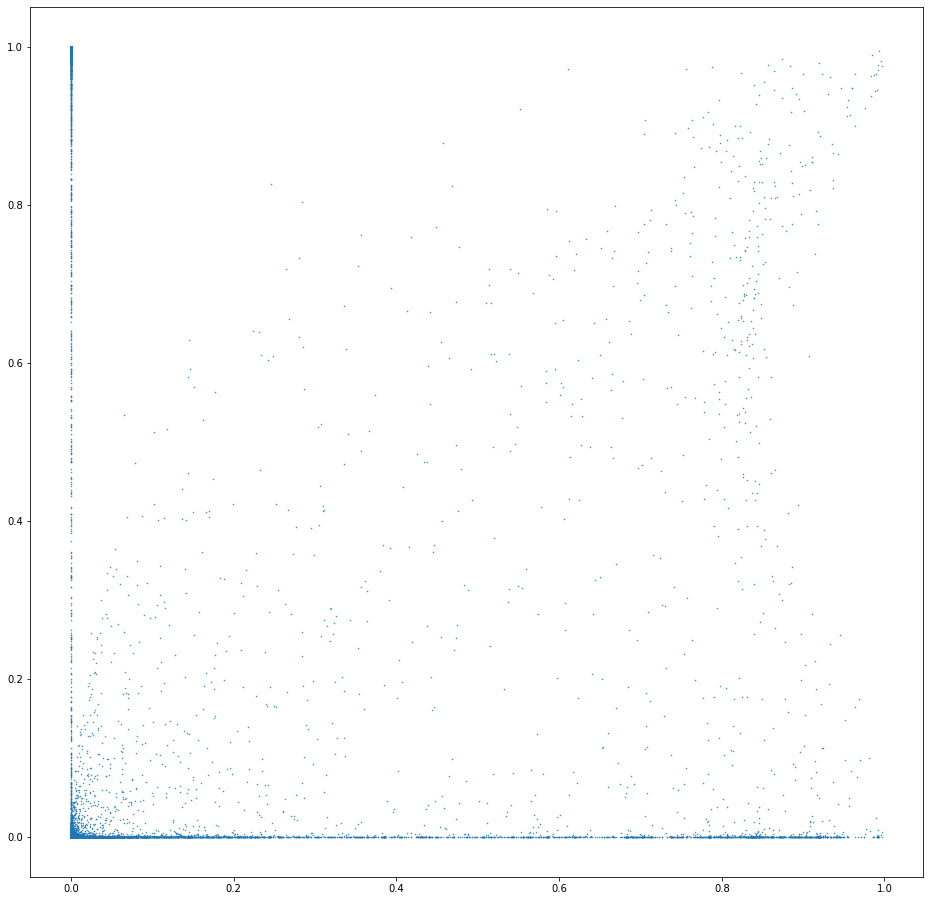

In [189]:
fig, ax0 = plt.subplots(figsize=(16,16))
ax0.scatter(x_o[:,14]*(1-y),x_o[:,6]*x_o[:,13], s=0.2)

In [145]:
len(y)
len(x)

11522

256.2467324733734


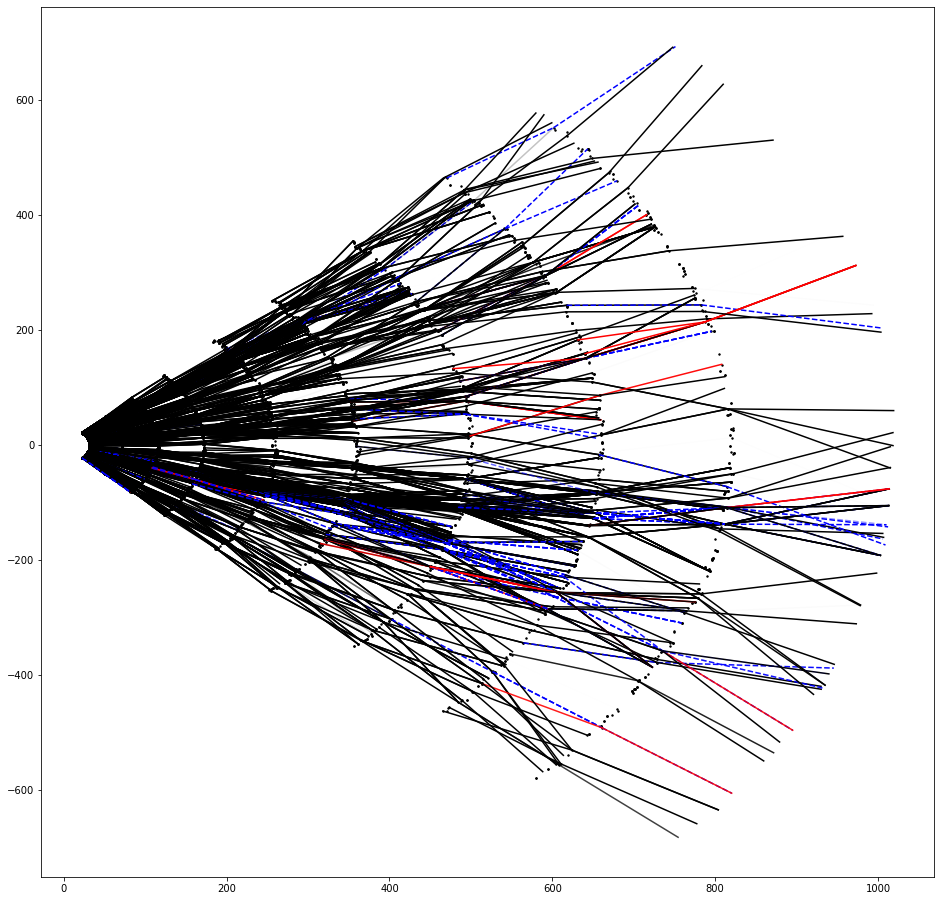

In [162]:
tic = tt()
draw_triplets_xy(x, e, o, y, cut=0.9);
print(tt()-tic)

In [161]:
def draw_triplets_xy(hits, edges, preds, labels, doublet=None, cut=0.5, figsize=(16, 16)):
    xi, yi = [hits[:,0] * np.cos(hits[:,1]), hits[:,0] * np.sin(hits[:,1])]
    xo, yo = [hits[:,3] * np.cos(hits[:,4]), hits[:,3] * np.sin(hits[:,4])]
    scores = hits[:,6]
    fig, ax0 = plt.subplots(figsize=figsize)

#     Draw the hits
    ax0.scatter(xi, yi, s=2, c='k')

    # Draw the segments
    #for j in range(labels.shape[0]):
    if doublet is None:
        for j in range(10000):

            # False negatives
            if preds[j] < cut and labels[j] > cut:
                ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                         [yi[edges[0,j]], yo[edges[0,j]]],
                         '--', c='b', alpha=(1-scores[j]))
                ax0.plot([xi[edges[1,j]], xo[edges[1,j]]],
                         [yi[edges[1,j]], yo[edges[1,j]]],
                         '--', c='b', alpha=(1-scores[j]))

            # False positives
            if preds[j] > cut and labels[j] < cut:
                ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                         [yi[edges[0,j]], yo[edges[0,j]]],
                         '-', c='r', alpha=preds[j])
            if preds[j] > cut and labels[j] < cut:
                ax0.plot([xi[edges[1,j]], xo[edges[1,j]]],
                         [yi[edges[1,j]], yo[edges[1,j]]],
                         '-', c='r', alpha=(1-scores[j]))

            # True positives
            if preds[j] > cut and labels[j] > cut:
                ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
                         [yi[edges[0,j]], yo[edges[0,j]]],
                         '-', c='k', alpha=(1-scores[j]))
            if preds[j] > cut and labels[j] > cut:
                ax0.plot([xi[edges[1,j]], xo[edges[1,j]]],
                         [yi[edges[1,j]], yo[edges[1,j]]],
                         '-', c='k', alpha=(1-scores[j]))

    return fig, ax0

## Colouring by Multiplicity

In [193]:
def add_multiplicity(hits, edges, preds, cut=0.5):
    mul = np.zeros(len(hits))
    w_mul = np.zeros(len(hits))
    for edge, pred in zip(edges.T, preds) :
        if pred > cut: 
            mul[edge[0]] += 1
            mul[edge[1]] += 1
            w_mul[edge[0]] += pred**2
            w_mul[edge[1]] += pred**2
#     return np.concatenate([hits, np.array([mul]).T], axis=1)
    return mul, w_mul

In [203]:
def draw_triplets_mul_xy(hits, edges, preds, labels, cut=0.5, figsize=(16, 16)):
    xi, yi = hits[:,0] * np.cos(hits[:,1]), hits[:,0] * np.sin(hits[:,1])
    xo, yo = hits[:,3] * np.cos(hits[:,4]), hits[:,3] * np.sin(hits[:,4])
    scores = hits[:,6]
    fig, ax0 = plt.subplots(figsize=figsize)
    cmap = plt.cm.seismic
    mul, w_mul = add_multiplicity(hits, edges, preds, cut)
#     Draw the hits
    ax0.scatter(xi, yi, s=2, c='k')

    # Draw the segments
    #for j in range(labels.shape[0]):
    for j in range(len(xi)):
        if (mul[j] == 1 or mul[j] == 2):
#             if (w_mul[j]/mul[j]) > cut:
            ax0.plot([xi[j],xo[j]],[yi[j],yo[j]], color=cmap(1-scores[j]))


    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])  # only needed for matplotlib < 3.1
    fig.colorbar(sm)
    return fig, ax0

29.452673196792603


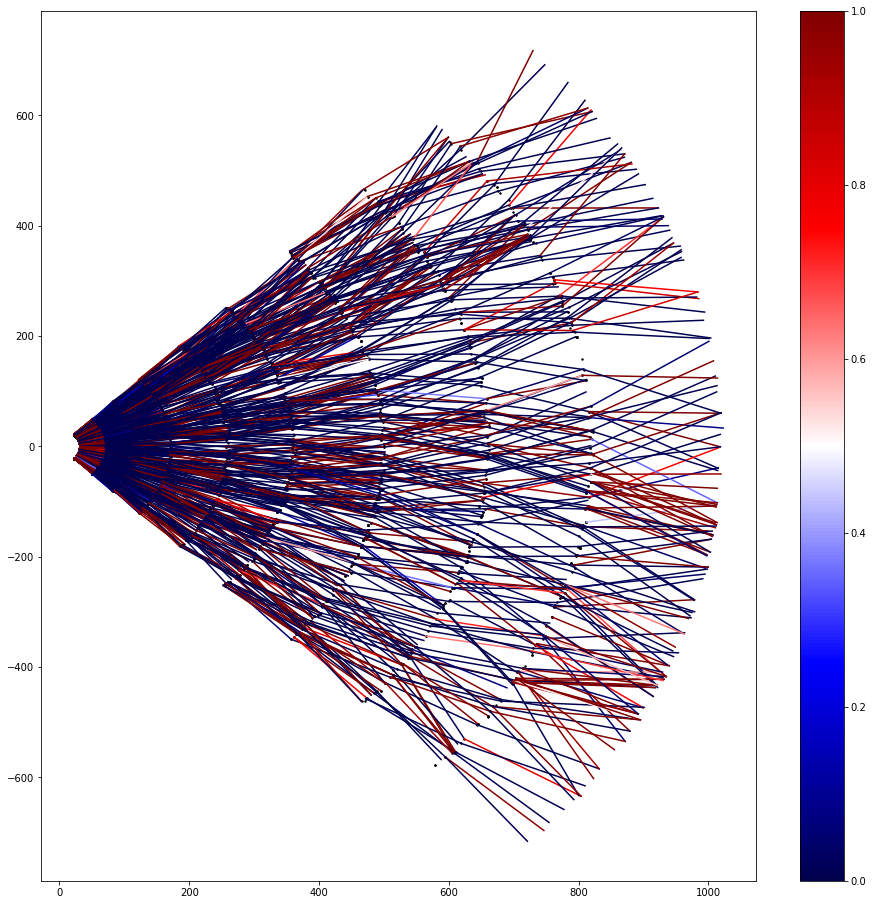

In [205]:
tic = tt()
draw_triplets_mul_xy(x, e, o, y, cut=0.95);
print(tt()-tic)

In [217]:
def tf_multiplicity(hits, edges, preds, labels, cut=0.5):
    """Include true/false (t/f) positive/negative (p/n) as {tp,fp,tn,fn}"""
    tf_mul = np.zeros((len(hits),4))
    for edge, pred, label in zip(edges.T, preds, labels) :
        # True positives
        tf_mul[edge[0]][0] += int((pred > cut) and (label > cut))
        tf_mul[edge[1]][0] += int((pred > cut) and (label > cut))
        # False positives
        tf_mul[edge[0]][1] += int((pred > cut) and (label < cut))
        tf_mul[edge[1]][1] += int((pred > cut) and (label < cut))
        # True negatives
        tf_mul[edge[0]][2] += int((pred < cut) and (label < cut))
        tf_mul[edge[1]][2] += int((pred < cut) and (label < cut))
        # False negatives
        tf_mul[edge[0]][3] += int((pred < cut) and (label > cut))
        tf_mul[edge[0]][3] += int((pred < cut) and (label > cut))
        
    return tf_mul

In [220]:
tf = tf_multiplicity(x, e, o, y, cut=0.9);

In [222]:
for t in tf:
    print(t)

[1. 0. 5. 0.]
[4. 0. 1. 0.]
[7. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[9. 0. 1. 0.]
[4. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 1. 0.]
[4. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 1. 0.]
[4. 0. 1. 0.]
[5. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 4. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[7. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 2. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[5. 0. 1. 0.]
[6. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 4. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[5. 0. 0. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 3. 0.]
[4. 0. 1. 0.]
[7. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[9. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 3. 0.]
[4. 0. 0. 0.]
[4. 0. 0. 0.]
[5. 0. 1. 0.]
[1. 0. 0. 0.]
[1. 0. 0. 0.]
[1. 0. 1. 0.]
[5. 0. 1. 0.]
[0. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[ 0.  

[3. 0. 1. 0.]
[2. 0. 0. 0.]
[0. 0. 1. 0.]
[1. 0. 2. 0.]
[3. 0. 0. 0.]
[0. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 0. 0.]
[7. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[6. 0. 1. 0.]
[0. 0. 1. 0.]
[3. 0. 1. 0.]
[ 0.  0. 10.  0.]
[6. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[6. 0. 1. 0.]
[11.  0.  1.  0.]
[6. 0. 1. 0.]
[7. 0. 1. 0.]
[8. 0. 1. 0.]
[10.  0.  1.  0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[1. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 4. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[6. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[8. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 9. 0.]
[8. 0. 1. 0.]
[6. 0. 1. 0.]
[5. 0. 1. 0.]
[6. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[6. 0. 1. 0.]
[3. 0. 1. 0.]
[7. 0. 1. 0.]
[8. 0. 1. 0.]
[4. 0. 1

[1. 0. 5. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 0. 0.]
[1. 0. 1. 0.]
[7. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[2. 0. 0. 0.]
[6. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 1. 2. 0.]
[0. 0. 1. 0.]
[1. 0. 0. 0.]
[1. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 4. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[6. 0. 1. 0.]
[0. 0. 1. 0.]
[4. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 1. 0.]
[8. 0. 1. 0.]
[3. 0. 1. 0.]
[8. 0. 1. 0.]
[8. 0. 1. 0.]
[3. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[4. 0. 1. 0.]
[8. 0. 1. 0.]
[8. 0. 1. 0.]
[5. 0. 1. 0.]
[8. 0. 1. 0.]
[3. 0. 1. 0.]
[8. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[6. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0.

[0. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 7. 0.]
[0. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 0. 0.]
[2. 0. 0. 0.]
[0. 0. 1. 0.]
[6. 0. 1. 0.]
[7. 0. 1. 0.]
[4. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 3. 0.]
[4. 0. 1. 0.]
[2. 0. 1. 0.]
[6. 0. 1. 0.]
[6. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[7. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[0. 0. 0. 0.]
[4. 0. 1. 0.]
[9. 0. 1. 0.]
[2. 0. 0. 0.]
[6. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 6. 0.]
[4. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 2. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 3. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[2. 0. 0. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[4. 0. 1. 0.]
[7. 0.

[1. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 0. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 2. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 0. 0.]
[2. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[8. 0. 1. 0.]
[6. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 3. 0.]
[2. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 1. 0.]
[6. 0. 1. 0.]
[0. 0. 0. 0.]
[4. 0. 1. 0.]
[1. 0. 1. 0.]
[4. 0. 0. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[0. 1. 0. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[6. 0. 1. 0.]
[6. 0. 1. 0.]
[0. 0. 1. 0.]
[10.  0.  1.  0.]
[6. 0. 1. 0.]
[7. 0. 1. 0.]
[5. 0. 1. 0.]
[8. 0. 1. 0.]
[8. 0. 1. 0.]
[7. 0. 1. 0.]
[8. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 6. 0.]
[4. 0. 1. 0.]
[8. 0. 1. 0.]
[5. 0. 1. 0.]
[8. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[4

[1. 0. 1. 0.]
[0. 0. 1. 0.]
[6. 0. 1. 0.]
[0. 0. 0. 0.]
[1. 0. 3. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[2. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 2. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[3. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[5. 0. 0. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[4. 0. 1. 0.]
[0. 0. 0. 0.]
[5. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[4. 0. 1. 0.]
[0. 0. 1. 0.]
[8. 0. 1. 0.]
[8. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[8. 0. 1. 0.]
[1. 0. 7. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[8. 0. 1. 0.]
[5. 0. 1. 0.]
[5. 0. 1. 0.]
[4. 0. 1. 0.]
[0. 0. 1. 0.]
[2. 1. 0. 0.]
[3. 0. 1. 0.]
[2. 1. 0. 0.]
[0. 0. 1. 0.]
[7. 0. 1. 0.]
[0. 0. 4. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[6. 0. 1. 0.]
[7. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[5. 0.

[5. 0. 1. 0.]
[6. 0. 1. 0.]
[10.  0.  1.  0.]
[7. 0. 0. 0.]
[1. 0. 3. 0.]
[4. 0. 1. 0.]
[7. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[5. 0. 1. 0.]
[6. 0. 1. 0.]
[3. 0. 1. 0.]
[6. 0. 1. 0.]
[1. 0. 3. 0.]
[2. 0. 1. 0.]
[2. 0. 1. 0.]
[4. 0. 1. 0.]
[3. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[9. 0. 1. 0.]
[10.  0.  1.  0.]
[3. 0. 1. 0.]
[9. 0. 1. 0.]
[6. 0. 1. 0.]
[11.  0.  1.  0.]
[7. 0. 1. 0.]
[9. 0. 1. 0.]
[5. 0. 1. 0.]
[8. 0. 1. 0.]
[10.  0.  1.  0.]
[7. 0. 0. 0.]
[3. 0. 1. 0.]
[0. 4. 0. 0.]
[0. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 3. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[4. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 6. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[3. 0. 1. 0.]
[5. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[2. 0. 0. 0.]
[3. 0. 1. 0.]
[1. 0. 1. 0.]
[1. 0. 2. 0.]
[0. 0. 1. 0.]
[1. 0. 0. 0.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[3. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 

[ 2.  0. 11.  0.]
[11.  0.  1.  0.]
[9. 0. 2. 0.]
[16.  0.  2.  0.]
[18.  0.  2.  0.]
[ 2.  0. 13.  0.]
[13.  0.  2.  0.]
[15.  0.  2.  0.]
[17.  0.  2.  0.]
[11.  0.  1.  2.]
[ 1.  0. 12.  0.]
[11.  0.  1.  2.]
[7. 0. 1. 0.]
[1. 0. 5. 0.]
[7. 0. 1. 0.]
[5. 0. 1. 0.]
[1. 0. 8. 0.]
[26.  0.  2.  0.]
[25.  0.  2.  0.]
[24.  0.  2.  0.]
[23.  0.  2.  0.]
[21.  0.  2.  0.]
[ 2.  0. 27.  0.]
[22.  0.  2.  0.]
[22.  0.  2.  0.]
[21.  0.  2.  0.]
[24.  0.  2.  0.]
[26.  0.  2.  0.]
[21.  0.  2.  0.]
[ 2.  0. 12.  0.]
[13.  0.  2.  0.]
[10.  0.  2.  0.]
[10.  0.  2.  0.]
[ 2.  0. 10.  0.]
[11.  0.  2.  0.]
[17.  0.  2.  0.]
[ 2.  0. 17.  0.]
[0. 0. 4. 0.]
[10.  0.  2.  0.]
[10.  0.  2.  0.]
[ 2.  0. 11.  0.]
[10.  0.  2.  0.]
[11.  0.  2.  0.]
[9. 0. 2. 0.]
[2. 0. 5. 0.]
[5. 0. 1. 0.]
[ 0.  0. 10.  2.]
[ 0.  0.  1. 20.]
[9. 0. 2. 2.]
[9. 1. 0. 2.]
[5. 0. 1. 0.]
[ 1.  0. 15.  2.]
[14.  0.  1.  2.]
[14.  0.  2.  2.]
[13.  0.  2.  2.]
[15.  0.  2.  2.]
[ 1.  1. 24.  0.]
[20.  0.  1.  2.]
[24.  0.

[7. 0. 2. 0.]
[13.  0.  2.  0.]
[13.  0.  2.  0.]
[12.  0.  2.  0.]
[ 2.  0. 13.  0.]
[13.  0.  2.  0.]
[14.  0.  2.  0.]
[11.  0.  2.  2.]
[11.  0.  1.  2.]
[ 2.  0. 11.  0.]
[12.  0.  2.  2.]
[9. 0. 2. 0.]
[10.  0.  2.  0.]
[2. 0. 9. 0.]
[10.  0.  2.  0.]
[8. 0. 2. 0.]
[8. 0. 1. 0.]
[9. 0. 2. 0.]
[8. 0. 2. 0.]
[2. 0. 9. 0.]
[19.  0.  2.  0.]
[19.  0.  2.  0.]
[ 2.  0. 20.  0.]
[8. 0. 2. 0.]
[7. 0. 2. 0.]
[2. 0. 6. 0.]
[7. 0. 2. 0.]
[1. 0. 9. 2.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[3. 0. 1. 0.]
[1. 0. 5. 0.]
[11.  0.  2.  0.]
[10.  0.  2.  0.]
[9. 0. 1. 0.]
[10.  0.  2.  0.]
[8. 0. 2. 0.]
[ 2.  0. 10.  0.]
[1. 0. 1. 0.]
[10.  0.  2.  0.]
[12.  0.  2.  0.]
[11.  0.  2.  0.]
[15.  0.  2.  2.]
[13.  0.  2.  2.]
[14.  0.  2.  2.]
[15.  0.  2.  2.]
[ 1.  0. 14.  2.]
[14.  0.  2.  4.]
[14.  0.  2.  2.]
[26.  0.  2.  0.]
[24.  0.  2.  0.]
[23.  0.  2.  0.]
[21.  0.  2.  0.]
[27.  0.  2.  0.]
[22.  0.  2.  0.]
[22.  0.  2.  0.]
[19.  0.  2.  0.]
[24.  0.  2.  0.]
[ 1.  0. 26.  2.]
[21.  0.  2.  0.]


[2. 0. 9. 0.]
[9. 0. 1. 0.]
[5. 0. 2. 0.]
[5. 0. 1. 0.]
[2. 0. 5. 0.]
[8. 0. 1. 0.]
[8. 0. 1. 0.]
[1. 0. 8. 0.]
[4. 0. 1. 0.]
[1. 0. 4. 0.]
[8. 0. 2. 0.]
[2. 0. 8. 0.]
[11.  0.  1.  0.]
[10.  0.  2.  0.]
[10.  0.  2.  0.]
[11.  0.  2.  0.]
[9. 0. 2. 0.]
[1. 0. 9. 2.]
[9. 0. 2. 0.]
[12.  0.  2.  0.]
[13.  0.  2.  0.]
[8. 0. 2. 0.]
[13.  0.  2.  0.]
[ 2.  0. 11.  0.]
[7. 0. 2. 0.]
[2. 0. 7. 0.]
[6. 0. 1. 0.]
[1. 0. 6. 0.]
[13.  0.  2.  2.]
[15.  0.  2.  2.]
[13.  0.  2.  2.]
[16.  0.  2.  2.]
[15.  0.  2.  2.]
[15.  0.  2.  2.]
[ 1.  0. 15.  2.]
[11.  0.  1.  0.]
[12.  0.  2.  0.]
[12.  0.  2.  0.]
[11.  0.  2.  0.]
[12.  0.  2.  0.]
[12.  0.  2.  0.]
[ 2.  0. 13.  0.]
[8. 0. 2. 0.]
[ 1.  0. 10.  0.]
[14.  0.  2.  0.]
[12.  0.  2.  0.]
[10.  0.  2.  0.]
[ 2.  0. 11.  0.]
[19.  0.  2.  0.]
[20.  0.  2.  0.]
[19.  0.  2.  0.]
[20.  0.  2.  0.]
[ 2.  0. 19.  0.]
[10.  0.  2.  0.]
[10.  0.  2.  0.]
[10.  0.  2.  0.]
[ 2.  0. 11.  0.]
[16.  0.  2.  0.]
[15.  0.  1.  0.]
[17.  0.  2.  0.]
[ 2.

[3. 1. 1. 0.]
[2. 0. 5. 0.]
[1. 0. 7. 2.]
[8. 0. 2. 0.]
[1. 1. 2. 0.]
[3. 1. 1. 0.]
[2. 0. 4. 0.]
[11.  0.  2.  0.]
[2. 0. 9. 0.]
[13.  0.  2.  0.]
[2. 0. 3. 0.]
[2. 0. 2. 0.]
[2. 0. 4. 0.]
[4. 0. 2. 0.]
[2. 0. 4. 0.]
[3. 0. 2. 0.]
[2. 0. 4. 0.]
[4. 0. 2. 0.]
[2. 0. 7. 0.]
[7. 0. 2. 0.]
[20.  0.  2.  0.]
[18.  0.  2.  0.]
[ 2.  0. 16.  0.]
[15.  0.  2.  0.]
[18.  0.  2.  0.]
[10.  0.  2.  0.]
[17.  0.  2.  0.]
[0. 0. 2. 0.]
[1. 0. 1. 0.]
[3. 0. 1. 0.]
[8. 0. 2. 0.]
[8. 0. 2. 0.]
[9. 0. 2. 0.]
[2. 0. 8. 0.]
[5. 0. 2. 0.]
[7. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 6. 0.]
[5. 0. 2. 0.]
[2. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 4. 0.]
[4. 0. 2. 0.]
[2. 0. 3. 0.]
[1. 0. 2. 0.]
[1. 0. 2. 0.]
[0. 0. 2. 2.]
[2. 0. 2. 2.]
[2. 0. 2. 2.]
[1. 0. 6. 2.]
[2. 0. 2. 2.]
[2. 0. 4. 0.]
[2. 0. 1. 0.]
[10.  0.  2.  0.]
[1. 1. 9. 0.]
[9. 0. 2. 0.]
[11.  0.  2.  0.]
[ 2.  0. 10.  0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[7. 0. 2. 0.]
[7. 0. 2. 0.]
[2. 0. 3. 0.]
[2. 0. 2. 0.]
[4. 0. 2. 0.]
[1. 0. 4. 0.]
[ 0. 10.  2.  2.]
[ 0.  0.  

[2. 0. 2. 0.]
[4. 0. 1. 2.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 6. 0.]
[2. 0. 4. 0.]
[2. 0. 2. 0.]
[5. 0. 2. 0.]
[7. 0. 2. 0.]
[2. 0. 7. 0.]
[3. 0. 2. 0.]
[1. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[5. 0. 2. 2.]
[2. 0. 5. 0.]
[9. 0. 2. 0.]
[2. 0. 7. 0.]
[5. 0. 2. 0.]
[4. 0. 1. 0.]
[5. 0. 2. 0.]
[2. 0. 5. 0.]
[8. 0. 2. 0.]
[10.  0.  2.  0.]
[2. 0. 8. 0.]
[0. 0. 1. 0.]
[2. 0. 1. 0.]
[8. 0. 2. 0.]
[2. 0. 8. 0.]
[9. 0. 2. 0.]
[7. 0. 1. 0.]
[6. 0. 2. 0.]
[4. 0. 1. 0.]
[2. 0. 7. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 4. 0.]
[5. 0. 2. 0.]
[7. 0. 2. 0.]
[7. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 7. 0.]
[2. 0. 1. 0.]
[7. 0. 2. 0.]
[8. 0. 2. 0.]
[2. 0. 5. 0.]
[6. 0. 2. 0.]
[5. 0. 2. 0.]
[2. 0. 7. 0.]
[8. 0. 2. 0.]
[2. 0. 9. 0.]
[7. 0. 1. 0.]
[1. 0. 1. 2.]
[2. 0. 1. 2.]
[2. 0. 0. 2.]
[1. 1. 0. 2.]
[4. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 4. 0.]
[1. 0. 7. 0.]
[7. 0. 2. 0.]
[6. 0. 1. 0.]
[2. 0. 4. 0.]
[7. 0. 2. 0.]
[9. 0. 2. 0.]
[2. 0. 9. 0.]
[6. 0. 2. 0.]
[5

[2. 0. 5. 0.]
[5. 0. 2. 0.]
[5. 0. 2. 0.]
[3. 0. 2. 0.]
[4. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 4. 0.]
[4. 0. 2. 0.]
[2. 0. 2. 0.]
[3. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 3. 0.]
[3. 0. 2. 0.]
[11.  0.  2.  0.]
[12.  0.  2.  0.]
[10.  0.  2.  0.]
[ 2.  0. 12.  0.]
[9. 0. 2. 0.]
[10.  0.  2.  0.]
[6. 0. 2. 0.]
[9. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 3. 0.]
[4. 1. 1. 2.]
[1. 0. 8. 2.]
[4. 0. 2. 2.]
[6. 0. 2. 0.]
[4. 0. 2. 0.]
[6. 0. 2. 0.]
[4. 0. 2. 0.]
[9. 0. 2. 0.]
[7. 0. 2. 0.]
[8. 0. 2. 0.]
[10.  0.  2.  0.]
[2. 0. 7. 0.]
[8. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[3. 0. 2. 0.]
[8. 0. 2. 0.]
[1. 0. 4. 0.]
[5. 0. 2. 0.]
[8. 0. 2. 0.]
[3. 0. 2. 0.]
[3. 0. 2. 0.]
[2. 0. 1. 0.]
[1. 0. 2. 0.]
[2. 0. 2. 0.]
[0. 2. 0. 2.]
[1. 0. 1. 4.]
[2. 0. 2. 0.]
[8. 0. 2. 0.]
[6. 0. 2. 0.]
[9. 0. 2. 0.]
[8. 0. 2. 0.]
[8. 0. 2. 0.]
[2. 0. 6. 0.]
[8. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 5. 0.]
[4. 0. 2. 0.]
[6. 0. 2. 0.]
[5. 0. 2. 0.]
[2. 0. 6. 0.]
[4. 0. 2. 0.]
[3. 0. 2. 0.]
[2. 0. 5. 0.]
[3. 0. 2. 0.]
[2. 0. 2. 

[5. 1. 1. 2.]
[8. 1. 1. 2.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[3. 0. 2. 0.]
[3. 0. 2. 0.]
[2. 0. 4. 0.]
[5. 0. 2. 0.]
[4. 0. 2. 0.]
[1. 0. 2. 0.]
[5. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 1. 0.]
[5. 0. 2. 0.]
[3. 0. 2. 0.]
[0. 0. 2. 2.]
[2. 0. 1. 0.]
[0. 0. 1. 4.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 0. 0.]
[ 2.  0. 10.  0.]
[10.  0.  1.  0.]
[10.  0.  2.  0.]
[7. 0. 2. 0.]
[9. 0. 2. 0.]
[10.  0.  2.  0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[2. 0. 3. 0.]
[4. 0. 2. 0.]
[4. 0. 1. 0.]
[5. 0. 2. 0.]
[2. 0. 1. 0.]
[2. 0. 2. 0.]
[1. 0. 1. 0.]
[2. 0. 2. 0.]
[ 2.  0. 11.  0.]
[9. 0. 2. 0.]
[10.  0.  1.  0.]
[10.  0.  2.  0.]
[7. 0. 2. 0.]
[9. 0. 2. 0.]
[11.  0.  2.  0.]
[8. 0. 2. 0.]
[7. 0. 1. 0.]
[10.  0.  2.  0.]
[2. 0. 2. 0.]
[2. 0. 3. 0.]
[3. 0. 2. 0.]
[0. 0. 5. 2.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 1. 0.]
[2. 0. 5. 0.]
[4. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 1. 0.]
[2. 0. 2. 0.]
[1. 0. 1. 0.]
[2. 0. 1. 0.]
[0. 0. 2. 0.]
[2. 0. 3. 0.]
[3. 0. 2. 0.]
[2. 0. 3. 0.]
[3. 0. 2. 0.]
[2. 0. 0. 0.]
[2. 0. 4. 0.]
[1. 0. 2. 0.

[3. 0. 2. 0.]
[4. 0. 1. 0.]
[2. 0. 4. 0.]
[3. 0. 2. 0.]
[2. 0. 2. 0.]
[1. 0. 1. 0.]
[1. 0. 1. 0.]
[15.  0.  2.  0.]
[13.  0.  2.  0.]
[13.  0.  2.  0.]
[10.  0.  2.  0.]
[10.  0.  2.  6.]
[15.  0.  2.  0.]
[2. 0. 3. 0.]
[3. 0. 2. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 6. 0.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[4. 0. 2. 0.]
[5. 0. 2. 0.]
[7. 0. 2. 0.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 7. 0.]
[9. 0. 2. 0.]
[9. 0. 1. 0.]
[9. 0. 2. 0.]
[6. 0. 1. 0.]
[2. 0. 9. 0.]
[2. 0. 7. 0.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[2. 0. 0. 0.]
[0. 0. 4. 2.]
[4. 0. 1. 0.]
[2. 0. 1. 0.]
[1. 0. 1. 0.]
[2. 0. 4. 0.]
[4. 0. 2. 0.]
[5. 0. 2. 0.]
[5. 0. 2. 0.]
[3. 0. 2. 0.]
[6. 0. 2. 0.]
[2. 0. 2. 0.]
[4. 0. 1. 0.]
[1. 0. 4. 0.]
[3. 0. 2. 0.]
[1. 0. 4. 0.]
[2. 0. 1. 0.]
[2. 1. 1. 0.]
[0. 0. 2. 0.]
[3. 0. 2. 0.]
[1. 0. 2. 0.]
[1. 0. 0. 0.]
[2. 0. 1. 0.]
[2. 0. 2. 0.]
[2. 0. 3. 0.]
[2. 0. 0. 0.]
[2. 0. 8. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[8. 0. 2. 0.]
[8. 0. 2. 0.]
[9. 0. 2. 

[2. 0. 1. 0.]
[4. 0. 2. 0.]
[3. 0. 2. 0.]
[2. 0. 4. 0.]
[8. 0. 2. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[7. 0. 2. 0.]
[8. 0. 2. 0.]
[2. 0. 9. 0.]
[5. 0. 2. 0.]
[7. 0. 2. 0.]
[4. 0. 2. 0.]
[5. 0. 2. 0.]
[2. 0. 6. 0.]
[2. 0. 1. 0.]
[7. 0. 2. 0.]
[7. 0. 2. 0.]
[7. 0. 2. 0.]
[8. 0. 2. 0.]
[1. 0. 5. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 2.]
[0. 0. 2. 6.]
[3. 0. 1. 2.]
[0. 0. 4. 2.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[1. 0. 2. 0.]
[2. 0. 1. 0.]
[2. 0. 1. 0.]
[6. 0. 1. 0.]
[4. 0. 1. 0.]
[6. 0. 1. 0.]
[2. 0. 1. 0.]
[7. 0. 2. 0.]
[5. 0. 2. 0.]
[6. 0. 2. 0.]
[1. 0. 6. 0.]
[2. 0. 2. 0.]
[2. 0. 2. 0.]
[5. 0. 2. 0.]
[4. 0. 2. 0.]
[2. 0. 4. 0.]
[6. 0. 2. 0.]
[6. 0. 2. 0.]
[7. 0. 2. 0.]
[5. 0. 2. 0.]
[9. 0. 2. 0.]
[6. 0. 1. 0.]
[2. 0. 7. 0.]
[4. 0. 2. 0.]
[5. 0. 2. 0.]
[7. 1. 1. 0.]
[3. 0. 2. 0.]
[2. 0. 6. 0.]
[2. 0. 1. 0.]
[0. 0. 1. 2.]
[1. 0. 2. 0.]
[1. 0. 2. 0.]
[2. 0. 1. 0.]
[2. 0. 6. 0.]
[6. 0. 2. 0.]
[2. 0. 2. 0.]
[0. 0. 2. 2.]
[0. 0. 2. 4.]
[0. 0. 2. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 2. 1. 0.]
[0. 0. 0. 6.]
[3. 0.

In [218]:
def draw_triplets_tf_mul_xy(hits, edges, preds, labels, cut=0.5, figsize=(16, 16)):
    xi, yi = hits[:,0] * np.cos(hits[:,1]), hits[:,0] * np.sin(hits[:,1])
    xo, yo = hits[:,3] * np.cos(hits[:,4]), hits[:,3] * np.sin(hits[:,4])
    scores = hits[:,6]
    fig, ax0 = plt.subplots(figsize=figsize)
    
    tf_mul = tf_multiplicity(hits, edges, preds, labels, cut)
#     Draw the hits
    ax0.scatter(xi, yi, s=2, c='k')
    ax0.scatter(xo, yo, s=2, c='k')
    print(tf_mul)
    # Draw the segments
    #for j in range(labels.shape[0]):
    for j in range(len(xi)):
        if ((tf_mul[j][0]==1 or tf_mul[j][0]==2) and tf_mul[j][1]==0 and 
            tf_mul[j][2]==0 and tf_mul[j][3]==0):
            ax0.plot([xi[j],xo[j]],[yi[j],yo[j]],
                     '-', c='#ffc70f')
        if (tf_mul[j][0]>2 and tf_mul[j][1]==0 and 
            tf_mul[j][2]==0 and tf_mul[j][3]==0):
            ax0.plot([xi[j],xo[j]],[yi[j],yo[j]],
                     '-', c='#982e06')
            
            
#         if (mul[j] == 1 or mul[j] == 2):
#             if (w_mul[j]/mul[j]) > cut:
#             ax0.plot([xi[j],xo[j]],[yi[j],yo[j]], color=cmap(1-scores[j]))
#         elif mul[j] == 3 or mul[j] == 4:
#             ax0.plot([xi[j],xo[j]],[yi[j],yo[j]], c='k')
#         elif mul[j] > 4:
#             ax0.plot([xi[j],xo[j]],[yi[j],yo[j]], c='k', alpha = (w_mul[j]/mul[j]))
        
#         # False negatives
#         if preds[j] < cut and labels[j] > cut:
#             ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
#                      [yi[edges[0,j]], yo[edges[0,j]]],
#                      '--', c='b')

#         # False positives
#         if preds[j] > cut and labels[j] < cut:
#             ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
#                      [yi[edges[0,j]], yo[edges[0,j]]],
#                      '-', c='r', alpha=preds[j])

#         # True positives
#         if preds[j] > cut and labels[j] > cut:
#             ax0.plot([xi[edges[0,j]], xo[edges[0,j]]],
#                      [yi[edges[0,j]], yo[edges[0,j]]],
#                      '-', c='k', alpha=preds[j])

    return fig, ax0

[[1. 0. 5. 0.]
 [4. 0. 1. 0.]
 [7. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
7.8451409339904785


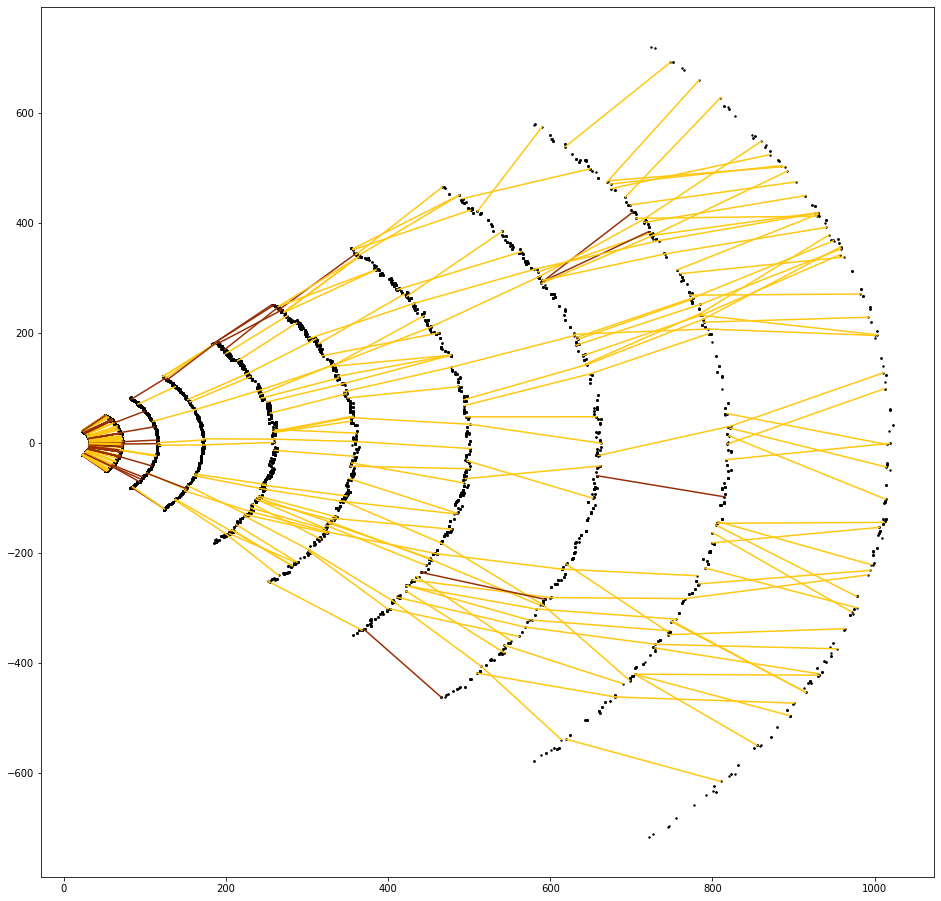

In [219]:
tic = tt()
draw_triplets_tf_mul_xy(x, e, o, y, cut=0.9);
print(tt()-tic)

## Writing data files

In [97]:
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)
test_preds, test_targets = trainer.predict(test_loader)

In [30]:
len(test_preds)

10

In [37]:
len(test_preds[1])

4263

In [44]:
g = test_loader.dataset[0]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [46]:
len(o)

53970

In [53]:
e[:,0]

array([5512,  347])

In [66]:
x[e[0,1000]],x[e[1,1000]]

(array([ 7.16653913e+01,  7.68787138e-01, -2.99602002e+01,  1.15002297e+02,
         7.83129915e-01, -1.07385002e+02,  6.83567996e-05]),
 array([ 3.19514759e+01,  7.61692056e-01, -2.77606994e+01,  7.16653913e+01,
         7.68787138e-01, -2.99602002e+01,  3.50703089e-03]))

In [58]:
y[0]

1.0

In [60]:
o[0]

0.99949276

## Resolve Multiplicities

## Play Area

In [225]:
for edge, pred, label in zip(e.T, o, y):
    print(edge, pred, label)

[4413    0] 0.99855894 1.0
[4413   51] 0.0014309598 0.0
[4413  206] 0.0011559377 0.0
[4413 1290] 0.0014689749 0.0
[4413 1447] 0.0014754322 0.0
[4413 2116] 0.001506932 0.0
[4413 2706] 0.0015007671 0.0
[4413 3635] 0.001484851 0.0
[4413 4282] 0.0014699096 0.0
[4413 4293] 0.0014858687 0.0
[4414    0] 0.025007974 0.0
[4414   51] 0.9999882 1.0
[4414  206] 0.9999869 1.0
[4414 1290] 0.9999889 1.0
[4414 1447] 0.9999883 1.0
[4414 2116] 0.9999887 1.0
[4414 2706] 0.9999883 1.0
[4414 3635] 0.99998784 1.0
[4414 4282] 0.9999888 1.0
[4414 4293] 0.99998844 1.0
[4415    0] 0.028466882 0.0
[4415   51] 0.99999034 1.0
[4415  206] 0.9999893 1.0
[4415 1290] 0.99999094 1.0
[4415 1447] 0.99999046 1.0
[4415 2116] 0.9999907 1.0
[4415 2706] 0.99999046 1.0
[4415 3635] 0.99999 1.0
[4415 4282] 0.9999908 1.0
[4415 4293] 0.99999046 1.0
[4416    0] 0.040429942 0.0
[4416   51] 0.9999871 1.0
[4416  206] 0.9999857 1.0
[4416 1290] 0.99998796 1.0
[4416 1447] 0.99998724 1.0
[4416 2116] 0.9999876 1.0
[4416 2706] 0.99998724 1.

[6185 5448] 0.06411479 0.0
[6185 5627] 0.0629522 0.0
[6186 4434] 0.023709789 0.0
[6186 5341] 0.99810326 1.0
[6186 5448] 0.99773943 1.0
[6186 5627] 0.99790406 1.0
[6187 4434] 0.0032642412 0.0
[6187 5341] 0.9999645 1.0
[6187 5448] 0.9999765 1.0
[6187 5627] 0.99996805 1.0
[6188 4434] 0.0031293689 0.0
[6188 5341] 0.99999034 1.0
[6188 5448] 0.99999404 1.0
[6188 5627] 0.99999106 1.0
[6189 4434] 0.002890562 0.0
[6189 5341] 0.9999902 1.0
[6189 5448] 0.9999938 1.0
[6189 5627] 0.99999094 1.0
[7373 6185] 0.11317633 0.0
[7373 6190] 0.99996746 1.0
[7373 6934] 0.999905 1.0
[7373 7068] 0.99993765 1.0
[7374 6185] 0.79686314 0.0
[7374 6190] 0.8638732 1.0
[7374 6934] 0.8580513 1.0
[7374 7068] 0.850182 1.0
[7375 6185] 0.06721287 0.0
[7375 6190] 0.99999106 1.0
[7375 6934] 0.99996006 1.0
[7375 7068] 0.9999809 1.0
[4438   59] 0.9957242 1.0
[4438  603] 0.015941443 0.0
[4438  638] 0.01592439 0.0
[4438  671] 0.01580459 0.0
[4438  824] 0.015885364 0.0
[4438 1310] 0.015803335 0.0
[4438 1509] 0.015749937 0.0
[443

[7379 6274] 0.9999969 1.0
[7379 6401] 0.9999912 1.0
[7379 6418] 0.9999956 1.0
[7379 6586] 0.9999969 1.0
[7379 6616] 0.99999154 1.0
[7379 6655] 0.9999969 1.0
[7379 6848] 0.99999607 1.0
[7379 6989] 0.99999285 1.0
[7380 6194] 0.001018563 0.0
[7380 6274] 0.99999714 1.0
[7380 6401] 0.99999213 1.0
[7380 6418] 0.99999595 1.0
[7380 6586] 0.99999714 1.0
[7380 6616] 0.99999225 1.0
[7380 6655] 0.999997 1.0
[7380 6848] 0.9999963 1.0
[7380 6989] 0.99999344 1.0
[7381 6194] 0.001196273 0.0
[7381 6274] 0.9999951 1.0
[7381 6401] 0.99998534 1.0
[7381 6418] 0.99999297 1.0
[7381 6586] 0.9999951 1.0
[7381 6616] 0.9999851 1.0
[7381 6655] 0.999995 1.0
[7381 6848] 0.99999356 1.0
[7381 6989] 0.9999881 1.0
[7382 6194] 0.0009847234 0.0
[7382 6274] 0.99999714 1.0
[7382 6401] 0.9999918 1.0
[7382 6418] 0.99999595 1.0
[7382 6586] 0.99999714 1.0
[7382 6616] 0.99999213 1.0
[7382 6655] 0.999997 1.0
[7382 6848] 0.9999963 1.0
[7382 6989] 0.9999933 1.0
[7383 6194] 0.00098538 0.0
[7383 6274] 0.99999714 1.0
[7383 6401] 0.99

[4466 3099] 0.0007915372 0.0
[4466 3120] 0.00079350645 0.0
[4466 3183] 0.00079398026 0.0
[4466 3197] 0.00079550856 0.0
[4466 3412] 0.00078600965 0.0
[4466 4029] 0.00079503335 0.0
[4467  119] 0.011036676 0.0
[4467  531] 0.99999523 1.0
[4467 1248] 0.999995 1.0
[4467 1800] 0.999995 1.0
[4467 2319] 0.9999951 1.0
[4467 2331] 0.9999951 1.0
[4467 3099] 0.999995 1.0
[4467 3120] 0.9999951 1.0
[4467 3183] 0.9999951 1.0
[4467 3197] 0.9999951 1.0
[4467 3412] 0.9999949 1.0
[4467 4029] 0.9999951 1.0
[6215 4466] 0.0013755766 0.0
[6216 4466] 0.99975544 1.0
[6217 4466] 0.0012703006 0.0
[7403 6216] 0.002874941 0.0
[7403 7246] 0.99999845 1.0
[7404 6216] 0.99954116 1.0
[7404 7246] 0.0012624513 0.0
[7405 6216] 0.0029669686 0.0
[7405 7246] 0.99999845 1.0
[8577 7404] 0.0013005636 0.0
[8577 8158] 0.9999944 1.0
[8578 7404] 0.99954873 1.0
[8578 8158] 0.01005994 0.0
[8579 7404] 0.0013323487 0.0
[8579 8158] 0.9999944 1.0
[9457 8578] 0.999521 1.0
[9457 9130] 0.003883261 0.0
[9458 8578] 0.0021942328 0.0
[9458 9130]

[7420 7154] 0.99999595 1.0
[8586 7416] 0.99972004 1.0
[8586 8324] 0.0007452143 0.0
[8586 8480] 0.00074693206 0.0
[8587 7416] 0.0013789093 0.0
[8587 8324] 0.9999962 1.0
[8587 8480] 0.9999968 1.0
[8588 7416] 0.0016548982 0.0
[8588 8324] 0.9999957 1.0
[8588 8480] 0.999997 1.0
[8589 7416] 0.001336397 0.0
[8589 8324] 0.9999962 1.0
[8589 8480] 0.9999969 1.0
[8590 7416] 0.0010363553 0.0
[8590 8324] 0.999998 1.0
[8590 8480] 0.9999982 1.0
[8591 7416] 0.0057000075 0.0
[8591 8324] 0.99997485 1.0
[8591 8480] 0.99998295 1.0
[8592 7416] 0.0017415257 0.0
[8592 8324] 0.9999949 1.0
[8592 8480] 0.99999666 1.0
[9466 8586] 0.9997638 1.0
[9466 8959] 0.0007762989 0.0
[9466 9257] 0.00068789674 0.0
[9466 9369] 0.00077885936 0.0
[9466 9418] 0.00079996587 0.0
[9467 8586] 0.0009943458 0.0
[9467 8959] 0.99999225 1.0
[9467 9257] 0.9999876 1.0
[9467 9369] 0.9999924 1.0
[9467 9418] 0.9999913 1.0
[9468 8586] 0.00084777694 0.0
[9468 8959] 0.99999833 1.0
[9468 9257] 0.9999969 1.0
[9468 9369] 0.9999976 1.0
[9468 9418] 0

[6247 4600] 0.99987245 1.0
[6247 4671] 0.9999716 1.0
[6247 4777] 0.99994206 1.0
[6247 4862] 0.9999697 1.0
[6247 5493] 0.49356574 1.0
[6247 5639] 0.99997187 1.0
[6247 5748] 0.99996865 1.0
[6247 5896] 0.9998802 1.0
[6248 4492] 0.91413856 0.0
[6248 4600] 0.9576503 1.0
[6248 4671] 0.98074806 1.0
[6248 4777] 0.96682656 1.0
[6248 4862] 0.98449993 1.0
[6248 5493] 0.6923647 1.0
[6248 5639] 0.98095787 1.0
[6248 5748] 0.978815 1.0
[6248 5896] 0.95892406 1.0
[6249 4492] 0.9207795 0.0
[6249 4600] 0.9998795 1.0
[6249 4671] 0.9999739 1.0
[6249 4777] 0.9999465 1.0
[6249 4862] 0.99997187 1.0
[6249 5493] 0.49558643 1.0
[6249 5639] 0.99997413 1.0
[6249 5748] 0.99997103 1.0
[6249 5896] 0.999887 1.0
[7431 6245] 0.9837087 1.0
[7431 6328] 0.0007868441 0.0
[7431 6904] 0.7844543 0.0
[7431 7089] 0.0008476098 0.0
[7431 7162] 0.00080831617 0.0
[7432 6245] 0.42941618 0.0
[7432 6328] 0.99998844 1.0
[7432 6904] 0.9079264 1.0
[7432 7089] 0.99999213 1.0
[7432 7162] 0.99998593 1.0
[7433 6245] 0.40614015 0.0
[7433 6328

[4505  367] 0.0031209192 0.0
[4505  386] 0.0015004226 0.0
[4505  498] 0.003189765 0.0
[4505 1047] 0.0031335382 0.0
[4505 1237] 0.0030415591 0.0
[4505 1460] 0.003210265 0.0
[4505 1590] 0.0030794411 0.0
[4505 2150] 0.002956667 0.0
[4505 2795] 0.0030425324 0.0
[4505 2849] 0.003014336 0.0
[4505 3281] 0.0031852257 0.0
[4505 3926] 0.0022868053 0.0
[4506  220] 0.020209769 0.0
[4506  367] 0.9999943 1.0
[4506  386] 0.9999907 1.0
[4506  498] 0.9999943 1.0
[4506 1047] 0.9999943 1.0
[4506 1237] 0.99999404 1.0
[4506 1460] 0.9999943 1.0
[4506 1590] 0.9999943 1.0
[4506 2150] 0.99999404 1.0
[4506 2795] 0.99999404 1.0
[4506 2849] 0.99999416 1.0
[4506 3281] 0.9999943 1.0
[4506 3926] 0.9999933 1.0
[4507  220] 0.028623547 0.0
[4507  367] 0.9999888 1.0
[4507  386] 0.99998045 1.0
[4507  498] 0.9999888 1.0
[4507 1047] 0.9999887 1.0
[4507 1237] 0.9999883 1.0
[4507 1460] 0.9999889 1.0
[4507 1590] 0.9999888 1.0
[4507 2150] 0.9999883 1.0
[4507 2795] 0.99998844 1.0
[4507 2849] 0.99998856 1.0
[4507 3281] 0.9999888

[4520 2715] 0.9999895 1.0
[4520 3860] 0.9999896 1.0
[4520 3990] 0.99998987 1.0
[4521   27] 0.9999931 1.0
[4521  255] 0.020571722 0.0
[4521 1303] 0.99999034 1.0
[4521 2185] 0.99999297 1.0
[4521 2390] 0.9999931 1.0
[4521 2715] 0.9999931 1.0
[4521 3860] 0.9999932 1.0
[4521 3990] 0.9999933 1.0
[6261 4518] 0.9994518 1.0
[6261 4934] 0.0010730666 0.0
[6261 5485] 0.0042481013 0.0
[6261 5960] 0.0039756936 0.0
[6262 4518] 0.0011138163 0.0
[6262 4934] 0.9999908 1.0
[6262 5485] 0.9999964 1.0
[6262 5960] 0.999998 1.0
[7459 6261] 0.99938464 1.0
[7459 6310] 0.0018275541 0.0
[7459 7081] 0.06675846 0.0
[7460 6261] 0.004296576 0.0
[7460 6310] 0.99999607 1.0
[7460 7081] 0.99906737 1.0
[7461 6261] 0.0040429765 0.0
[7461 6310] 0.9999962 1.0
[7461 7081] 0.9990074 1.0
[8623 7459] 0.99962246 1.0
[8623 8262] 0.002637178 0.0
[8624 7459] 0.002483329 0.0
[8624 8262] 0.99999666 1.0
[8625 7459] 0.0025627143 0.0
[8625 8262] 0.9999968 1.0
[9505 8623] 0.99952304 1.0
[9506 8623] 0.002844892 0.0
[10264  9505] 0.99952364

[7464 6730] 0.9982388 1.0
[7464 6791] 0.99824774 1.0
[7465 6268] 0.99681795 1.0
[7465 6392] 0.13884635 0.0
[7465 6730] 0.1383951 0.0
[7465 6791] 0.13882329 0.0
[7466 6268] 0.0033876237 0.0
[7466 6392] 0.99999726 1.0
[7466 6730] 0.99999726 1.0
[7466 6791] 0.9999974 1.0
[7467 6268] 0.0035167246 0.0
[7467 6392] 0.9999975 1.0
[7467 6730] 0.9999974 1.0
[7467 6791] 0.9999975 1.0
[7468 6268] 0.0032726806 0.0
[7468 6392] 0.9999975 1.0
[7468 6730] 0.9999974 1.0
[7468 6791] 0.9999975 1.0
[7469 6268] 0.0034746309 0.0
[7469 6392] 0.9999975 1.0
[7469 6730] 0.9999974 1.0
[7469 6791] 0.9999975 1.0
[7470 6268] 0.0032983988 0.0
[7470 6392] 0.9999975 1.0
[7470 6730] 0.9999975 1.0
[7470 6791] 0.9999976 1.0
[7471 6268] 0.0035357838 0.0
[7471 6392] 0.9999974 1.0
[7471 6730] 0.99999726 1.0
[7471 6791] 0.9999974 1.0
[8628 7455] 0.09723815 0.0
[8628 7465] 0.99605006 1.0
[8628 7599] 0.0021769674 0.0
[8628 7925] 0.002159518 0.0
[8628 7974] 0.0021645753 0.0
[8629 7455] 0.997324 1.0
[8629 7465] 0.16050787 0.0
[86

[7479 6714] 0.9999944 1.0
[7479 6797] 0.99998975 1.0
[7479 6925] 0.9999933 1.0
[7479 7232] 0.99999464 1.0
[8632 7474] 0.0035897477 0.0
[8633 7474] 0.99912065 1.0
[8634 7474] 0.0039743474 0.0
[8635 7474] 0.0038573986 0.0
[8636 7474] 0.003933393 0.0
[8637 7474] 0.0037699041 0.0
[9512 8569] 0.0023793878 0.0
[9512 8633] 0.9993259 1.0
[9513 8569] 0.9999968 1.0
[9513 8633] 0.005923604 0.0
[9514 8569] 0.99999666 1.0
[9514 8633] 0.006047316 0.0
[9515 8569] 0.99999666 1.0
[9515 8633] 0.0060779518 0.0
[9516 8569] 0.9999962 1.0
[9516 8633] 0.0060744644 0.0
[10271  9433] 0.00477731 0.0
[10271  9512] 0.9995146 1.0
[10272  9433] 0.999997 1.0
[10272  9512] 0.0020870296 0.0
[10273  9433] 0.99999654 1.0
[10273  9512] 0.0021663443 0.0
[10274  9433] 0.99999666 1.0
[10274  9512] 0.0021149174 0.0
[10865 10271] 0.9991503 1.0
[11245 10865] 0.8731779 1.0
[11246 10865] 0.76290095 0.0
[4553  309] 0.9746415 1.0
[4553  893] 0.14619528 0.0
[4553  967] 0.14661372 0.0
[4553 1150] 0.1516544 0.0
[4553 1339] 0.14643155

[4570 1462] 0.0009845162 0.0
[4570 3208] 0.0004796222 0.0
[4570 3282] 0.0025527366 0.0
[4570 3908] 0.0010132587 0.0
[4570 3927] 0.000995183 0.0
[4570 3942] 0.0010186746 0.0
[4570 4360] 0.00066913484 0.0
[4571  368] 0.04648143 0.0
[4571  499] 0.99996114 1.0
[4571 1048] 0.99999297 1.0
[4571 1403] 0.9999931 1.0
[4571 1462] 0.99999297 1.0
[4571 3208] 0.9999883 1.0
[4571 3282] 0.99990857 1.0
[4571 3908] 0.99999285 1.0
[4571 3927] 0.99999285 1.0
[4571 3942] 0.99999297 1.0
[4571 4360] 0.99999154 1.0
[4572  368] 0.048026282 0.0
[4572  499] 0.99996233 1.0
[4572 1048] 0.99999297 1.0
[4572 1403] 0.9999931 1.0
[4572 1462] 0.9999931 1.0
[4572 3208] 0.99998844 1.0
[4572 3282] 0.9999125 1.0
[4572 3908] 0.99999297 1.0
[4572 3927] 0.99999297 1.0
[4572 3942] 0.99999297 1.0
[4572 4360] 0.99999166 1.0
[4573  368] 0.048787944 0.0
[4573  499] 0.9999609 1.0
[4573 1048] 0.9999927 1.0
[4573 1403] 0.99999297 1.0
[4573 1462] 0.99999285 1.0
[4573 3208] 0.9999881 1.0
[4573 3282] 0.9999095 1.0
[4573 3908] 0.9999927

[4585  131] 0.034120575 0.0
[4585  246] 0.035221394 0.0
[4585  429] 0.99309385 1.0
[4585  627] 0.05575382 0.0
[4585 1161] 0.034250807 0.0
[4585 1583] 0.017668879 0.0
[4585 2237] 0.034879323 0.0
[4585 2284] 0.0011572245 0.0
[4585 2428] 0.03513523 0.0
[4585 3441] 0.033688348 0.0
[4585 3595] 0.03440924 0.0
[4585 3689] 0.033967685 0.0
[4585 4006] 0.03457401 0.0
[4585 4106] 0.034148045 0.0
[4585 4390] 0.03411561 0.0
[4586  131] 0.9999821 1.0
[4586  246] 0.999982 1.0
[4586  429] 0.06467753 0.0
[4586  627] 0.99749714 1.0
[4586 1161] 0.99998164 1.0
[4586 1583] 0.99996936 1.0
[4586 2237] 0.99998164 1.0
[4586 2284] 0.99990094 1.0
[4586 2428] 0.999982 1.0
[4586 3441] 0.99998176 1.0
[4586 3595] 0.99998176 1.0
[4586 3689] 0.9999826 1.0
[4586 4006] 0.9999827 1.0
[4586 4106] 0.99998224 1.0
[4586 4390] 0.99998164 1.0
[4587  131] 0.9999838 1.0
[4587  246] 0.99998367 1.0
[4587  429] 0.06938637 0.0
[4587  627] 0.99761593 1.0
[4587 1161] 0.9999833 1.0
[4587 1583] 0.99997234 1.0
[4587 2237] 0.9999833 1.0
[

[8667 7868] 0.005582606 0.0
[8667 8039] 0.0034329074 0.0
[8667 8052] 0.0034088662 0.0
[8667 8389] 0.0032378202 0.0
[9539 8667] 0.999511 1.0
[10290  9539] 0.99902236 1.0
[4599  162] 0.0021933329 0.0
[4599  465] 0.99813664 1.0
[4599  542] 0.0021874146 0.0
[4599 1491] 0.0021740214 0.0
[4599 1832] 0.0060160523 0.0
[4599 2311] 0.002146222 0.0
[4599 2903] 0.0021776014 0.0
[4599 3482] 0.0021837791 0.0
[6327 4599] 0.9998022 1.0
[6327 5116] 0.0020268818 0.0
[6327 5772] 0.002277336 0.0
[7524 6327] 0.99965405 1.0
[7524 6528] 0.0025197181 0.0
[7524 6674] 0.00223643 0.0
[7524 6681] 0.002540449 0.0
[8668 7524] 0.9996251 1.0
[8668 7865] 0.007006634 0.0
[8668 7875] 0.00818851 0.0
[4600  182] 0.99882895 1.0
[4600  472] 0.86621493 0.0
[4600 1810] 0.9990625 1.0
[4600 2722] 0.95116246 1.0
[4600 3055] 0.99904424 1.0
[4600 3718] 0.9279249 1.0
[4600 4269] 0.9990695 1.0
[4601  182] 0.83568054 0.0
[4601  472] 0.8434607 1.0
[4601 1810] 0.83660525 0.0
[4601 2722] 0.8392566 0.0
[4601 3055] 0.8364932 0.0
[4601 371

[9550 9098] 0.9999987 1.0
[9550 9208] 0.99999905 1.0
[9551 8603] 0.9999988 1.0
[9551 8670] 0.9999981 1.0
[9551 8679] 0.00075546355 0.0
[9551 9062] 0.99999845 1.0
[9551 9082] 0.99999845 1.0
[9551 9098] 0.999998 1.0
[9551 9208] 0.99999845 1.0
[9552 8603] 0.99999905 1.0
[9552 8670] 0.99999857 1.0
[9552 8679] 0.0007649766 0.0
[9552 9062] 0.9999988 1.0
[9552 9082] 0.9999988 1.0
[9552 9098] 0.99999845 1.0
[9552 9208] 0.9999988 1.0
[9553 8603] 0.99999416 1.0
[9553 8670] 0.9999912 1.0
[9553 8679] 0.0009798025 0.0
[9553 9062] 0.9999926 1.0
[9553 9082] 0.99999344 1.0
[9553 9098] 0.99999213 1.0
[9553 9208] 0.9999931 1.0
[10296  9483] 0.9992823 1.0
[10296  9547] 0.08063193 0.0
[10296  9896] 0.9992274 1.0
[10296 10148] 0.9992781 1.0
[10296 10159] 0.99868006 1.0
[10296 10181] 0.99721813 1.0
[10297  9483] 0.23600838 0.0
[10297  9547] 0.9908636 1.0
[10297  9896] 0.23507394 0.0
[10297 10148] 0.23704936 0.0
[10297 10159] 0.21599188 0.0
[10297 10181] 0.19018349 0.0
[10298  9483] 0.99997056 1.0
[10298  95

[4629  533] 0.9988477 1.0
[4629 1277] 0.00048006105 0.0
[4629 2320] 0.0004874778 0.0
[4629 2332] 0.00048781224 0.0
[4629 2882] 0.00046511285 0.0
[4629 3121] 0.00048711436 0.0
[4629 3184] 0.00048670912 0.0
[4629 3198] 0.00048751384 0.0
[4629 3368] 0.00048528254 0.0
[4629 4030] 0.00047026353 0.0
[4629 4302] 0.00048577035 0.0
[4630  120] 0.99999094 1.0
[4630  533] 0.035845947 0.0
[4630 1277] 0.99999106 1.0
[4630 2320] 0.99999106 1.0
[4630 2332] 0.99999094 1.0
[4630 2882] 0.9999908 1.0
[4630 3121] 0.99999106 1.0
[4630 3184] 0.99999106 1.0
[4630 3198] 0.99999106 1.0
[4630 3368] 0.99999094 1.0
[4630 4030] 0.9999908 1.0
[4630 4302] 0.9999912 1.0
[4631  120] 0.9999943 1.0
[4631  533] 0.019320996 0.0
[4631 1277] 0.9999944 1.0
[4631 2320] 0.9999944 1.0
[4631 2332] 0.9999944 1.0
[4631 2882] 0.9999943 1.0
[4631 3121] 0.9999944 1.0
[4631 3184] 0.9999944 1.0
[4631 3198] 0.9999944 1.0
[4631 3368] 0.9999944 1.0
[4631 4030] 0.99999416 1.0
[4631 4302] 0.9999945 1.0
[4632  120] 0.9999949 1.0
[4632  533] 

[9565 8712] 0.999622 1.0
[10308  9601] 0.9834683 1.0
[10308 10048] 0.9898643 1.0
[10308 10105] 0.9978666 1.0
[10309  9601] 0.99244237 1.0
[10309 10048] 0.99625635 1.0
[10309 10105] 0.9995906 1.0
[10883 10454] 0.9991504 1.0
[10883 10732] 0.9991596 1.0
[11260 11016] 0.95898753 1.0
[4652  489] 0.9998926 1.0
[4652 1383] 0.999894 1.0
[4652 2269] 0.999894 1.0
[4652 2599] 0.99989045 1.0
[4652 3416] 0.9998617 1.0
[4652 3749] 0.99989057 1.0
[4652 3776] 0.9999019 1.0
[4652 3892] 0.99989104 1.0
[4653  489] 0.99993134 1.0
[4653 1383] 0.9999323 1.0
[4653 2269] 0.9999324 1.0
[4653 2599] 0.9999299 1.0
[4653 3416] 0.9999112 1.0
[4653 3749] 0.99993 1.0
[4653 3776] 0.9999374 1.0
[4653 3892] 0.9999305 1.0
[4654  489] 0.9999529 1.0
[4654 1383] 0.9999536 1.0
[4654 2269] 0.99995387 1.0
[4654 2599] 0.99995184 1.0
[4654 3416] 0.9999392 1.0
[4654 3749] 0.99995196 1.0
[4654 3776] 0.9999573 1.0
[4654 3892] 0.99995255 1.0
[4655  489] 0.9994511 1.0
[4655 1383] 0.99945265 1.0
[4655 2269] 0.99944514 1.0
[4655 2599] 

[4670 2732] 0.99999416 1.0
[4670 3056] 0.9999864 1.0
[4670 3719] 0.9999945 1.0
[4670 4173] 0.9999943 1.0
[4670 4270] 0.9999945 1.0
[4671  183] 0.99998665 1.0
[4671  233] 0.9999864 1.0
[4671  651] 0.031567488 0.0
[4671  714] 0.999987 1.0
[4671  910] 0.99998665 1.0
[4671 1133] 0.9999869 1.0
[4671 1617] 0.9999869 1.0
[4671 2193] 0.99998677 1.0
[4671 2732] 0.9999862 1.0
[4671 3056] 0.99996567 1.0
[4671 3719] 0.99998677 1.0
[4671 4173] 0.9999864 1.0
[4671 4270] 0.999987 1.0
[4672  183] 0.9999924 1.0
[4672  233] 0.99999225 1.0
[4672  651] 0.022692861 0.0
[4672  714] 0.9999926 1.0
[4672  910] 0.9999924 1.0
[4672 1133] 0.9999925 1.0
[4672 1617] 0.9999925 1.0
[4672 2193] 0.9999925 1.0
[4672 2732] 0.99999213 1.0
[4672 3056] 0.9999813 1.0
[4672 3719] 0.9999925 1.0
[4672 4173] 0.99999225 1.0
[4672 4270] 0.9999926 1.0
[4673  183] 0.0007103805 0.0
[4673  233] 0.0007115134 0.0
[4673  651] 0.99921596 1.0
[4673  714] 0.0007203031 0.0
[4673  910] 0.0007144667 0.0
[4673 1133] 0.00072004774 0.0
[4673 1617

[7589 6376] 0.9999969 1.0
[7589 6385] 0.0009161265 0.0
[7589 6871] 0.9999969 1.0
[7589 7301] 0.9999968 1.0
[7590 6376] 0.0011148555 0.0
[7590 6385] 0.99976104 1.0
[7590 6871] 0.0010720581 0.0
[7590 7301] 0.0010947019 0.0
[7591 6376] 0.9999943 1.0
[7591 6385] 0.00095884065 0.0
[7591 6871] 0.9999944 1.0
[7591 7301] 0.9999943 1.0
[7592 6376] 0.9999964 1.0
[7592 6385] 0.0007796617 0.0
[7592 6871] 0.99999654 1.0
[7592 7301] 0.9999964 1.0
[7593 6376] 0.9999976 1.0
[7593 6385] 0.0008198305 0.0
[7593 6871] 0.9999976 1.0
[7593 7301] 0.9999975 1.0
[8720 7590] 0.9997359 1.0
[8720 8034] 0.0015473976 0.0
[8720 8478] 0.0014283158 0.0
[8721 7590] 0.0012766205 0.0
[8721 8034] 0.9999957 1.0
[8721 8478] 0.9999976 1.0
[9580 8720] 0.9997348 1.0
[9580 9367] 0.0028960274 0.0
[9581 8720] 0.0016752628 0.0
[9581 9367] 0.99999917 1.0
[9582 8720] 0.0016295656 0.0
[9582 9367] 0.99999917 1.0
[10320  9580] 0.9464029 1.0
[10320  9753] 0.6874288 0.0
[10320 10155] 0.71540076 0.0
[10321  9580] 0.3150401 0.0
[10321  975

[8735 8128] 0.99763703 1.0
[8735 8253] 0.9961189 1.0
[8736 7373] 0.22663142 0.0
[8736 7376] 0.6069336 0.0
[8736 8128] 0.17449164 0.0
[8736 8253] 0.2296594 0.0
[8737 7373] 0.97632617 1.0
[8737 7376] 0.9514721 1.0
[8737 8128] 0.98457664 1.0
[8737 8253] 0.9793084 1.0
[9589 8736] 0.19604081 0.0
[9589 9116] 0.9998652 1.0
[9590 8736] 0.15318191 0.0
[9590 9116] 0.9999871 1.0
[9591 8736] 0.9938253 1.0
[9591 9116] 0.008990233 0.0
[9592 8736] 0.1497302 0.0
[9592 9116] 0.9999957 1.0
[9593 8736] 0.1681194 0.0
[9593 9116] 0.99947566 1.0
[10328  9429] 0.9999968 1.0
[10328  9494] 0.9999969 1.0
[10328  9591] 0.010530607 0.0
[10328  9932] 0.99999785 1.0
[10329  9429] 0.01953023 0.0
[10329  9494] 0.019008214 0.0
[10329  9591] 0.99805284 1.0
[10329  9932] 0.018997056 0.0
[10330  9429] 0.99999714 1.0
[10330  9494] 0.99999714 1.0
[10330  9591] 0.008285786 0.0
[10330  9932] 0.999998 1.0
[10899 10257] 0.9999882 1.0
[10899 10329] 0.016318966 0.0
[4710   74] 0.8343498 1.0
[4710  295] 0.8236587 1.0
[4710  770] 

[7611 6195] 0.9999956 1.0
[7611 6276] 0.9999982 1.0
[7611 6402] 0.0011841542 0.0
[7611 6420] 0.9999975 1.0
[7611 6480] 0.9999974 1.0
[7611 6587] 0.9999982 1.0
[7611 6849] 0.99999774 1.0
[7612 6195] 0.9999945 1.0
[7612 6276] 0.99999774 1.0
[7612 6402] 0.0013240228 0.0
[7612 6420] 0.9999969 1.0
[7612 6480] 0.9999968 1.0
[7612 6587] 0.99999774 1.0
[7612 6849] 0.99999714 1.0
[7613 6195] 0.9999938 1.0
[7613 6276] 0.9999975 1.0
[7613 6402] 0.0014013033 0.0
[7613 6420] 0.99999654 1.0
[7613 6480] 0.9999963 1.0
[7613 6587] 0.9999975 1.0
[7613 6849] 0.9999968 1.0
[7614 6195] 0.9999944 1.0
[7614 6276] 0.99999774 1.0
[7614 6402] 0.0013234755 0.0
[7614 6420] 0.9999969 1.0
[7614 6480] 0.99999666 1.0
[7614 6587] 0.99999774 1.0
[7614 6849] 0.99999714 1.0
[7615 6195] 0.9999944 1.0
[7615 6276] 0.99999774 1.0
[7615 6402] 0.0013536569 0.0
[7615 6420] 0.9999968 1.0
[7615 6480] 0.99999666 1.0
[7615 6587] 0.99999774 1.0
[7615 6849] 0.999997 1.0
[7616 6195] 0.9999943 1.0
[7616 6276] 0.99999774 1.0
[7616 6402]

[4742 2028] 0.9999589 1.0
[4742 2045] 0.9999589 1.0
[4742 2536] 0.993457 1.0
[4742 2585] 0.9999585 1.0
[4742 3508] 0.99995995 1.0
[4742 3911] 0.9999584 1.0
[4742 3945] 0.99995863 1.0
[4743  513] 0.9999863 1.0
[4743  809] 0.14537272 0.0
[4743  895] 0.9999863 1.0
[4743 1342] 0.99998677 1.0
[4743 1405] 0.99998677 1.0
[4743 2028] 0.9999864 1.0
[4743 2045] 0.9999864 1.0
[4743 2536] 0.9963865 1.0
[4743 2585] 0.9999863 1.0
[4743 3508] 0.9999869 1.0
[4743 3911] 0.9999862 1.0
[4743 3945] 0.9999863 1.0
[6418 4545] 0.99999595 1.0
[6418 4737] 0.02138697 0.0
[6418 4771] 0.9999964 1.0
[6418 4941] 0.9999962 1.0
[6418 5404] 0.998042 1.0
[6418 5525] 0.99999285 1.0
[6418 5919] 0.99998534 1.0
[6419 4545] 0.99999547 1.0
[6419 4737] 0.0223658 0.0
[6419 4771] 0.99999595 1.0
[6419 4941] 0.9999958 1.0
[6419 5404] 0.998192 1.0
[6419 5525] 0.999992 1.0
[6419 5919] 0.99998355 1.0
[6420 4545] 0.99999607 1.0
[6420 4737] 0.02220799 0.0
[6420 4771] 0.9999964 1.0
[6420 4941] 0.9999963 1.0
[6420 5404] 0.99816257 1.0
[

[6426 4546] 0.011245574 0.0
[6426 4712] 0.012671772 0.0
[6426 4753] 0.9149206 1.0
[6426 4915] 0.5967718 0.0
[6426 4979] 0.011625321 0.0
[6426 5091] 0.012356678 0.0
[6426 5612] 0.016712021 0.0
[6427 4444] 0.9999826 1.0
[6427 4546] 0.99999213 1.0
[6427 4712] 0.9999833 1.0
[6427 4753] 0.66954494 0.0
[6427 4915] 0.9394222 1.0
[6427 4979] 0.999992 1.0
[6427 5091] 0.99999225 1.0
[6427 5612] 0.9999807 1.0
[6428 4444] 0.99998224 1.0
[6428 4546] 0.99999166 1.0
[6428 4712] 0.99998295 1.0
[6428 4753] 0.62001884 0.0
[6428 4915] 0.92624456 1.0
[6428 4979] 0.99999154 1.0
[6428 5091] 0.9999918 1.0
[6428 5612] 0.9999802 1.0
[6429 4444] 0.9999337 1.0
[6429 4546] 0.99997437 1.0
[6429 4712] 0.9999354 1.0
[6429 4753] 0.6664263 0.0
[6429 4915] 0.9176636 1.0
[6429 4979] 0.999974 1.0
[6429 5091] 0.99997365 1.0
[6429 5612] 0.9999496 1.0
[6430 4444] 0.99998295 1.0
[6430 4546] 0.999992 1.0
[6430 4712] 0.99998367 1.0
[6430 4753] 0.6411245 0.0
[6430 4915] 0.93254024 1.0
[6430 4979] 0.999992 1.0
[6430 5091] 0.9999

[4776 2586] 0.9999927 1.0
[4776 3509] 0.99999297 1.0
[4776 3912] 0.9999926 1.0
[4776 3946] 0.9999927 1.0
[6439 4571] 0.99999726 1.0
[6439 4617] 0.9999958 1.0
[6439 4738] 0.9999956 1.0
[6439 4772] 0.0007798597 0.0
[6439 4831] 0.999997 1.0
[6439 5691] 0.999997 1.0
[6439 5718] 0.9999962 1.0
[6440 4571] 0.99999535 1.0
[6440 4617] 0.99999297 1.0
[6440 4738] 0.9999926 1.0
[6440 4772] 0.0011822911 0.0
[6440 4831] 0.99999523 1.0
[6440 5691] 0.999995 1.0
[6440 5718] 0.9999937 1.0
[6441 4571] 0.0010459557 0.0
[6441 4617] 0.0010727625 0.0
[6441 4738] 0.0011580592 0.0
[6441 4772] 0.99962354 1.0
[6441 4831] 0.0010386583 0.0
[6441 5691] 0.0010559337 0.0
[6441 5718] 0.0010031535 0.0
[6442 4571] 0.999997 1.0
[6442 4617] 0.99999547 1.0
[6442 4738] 0.9999951 1.0
[6442 4772] 0.0007947823 0.0
[6442 4831] 0.9999968 1.0
[6442 5691] 0.9999968 1.0
[6442 5718] 0.9999958 1.0
[6443 4571] 0.9999974 1.0
[6443 4617] 0.9999958 1.0
[6443 4738] 0.9999957 1.0
[6443 4772] 0.0007755702 0.0
[6443 4831] 0.99999714 1.0
[644

[4791  334] 0.97608745 1.0
[4791  450] 0.99997723 1.0
[4791  931] 0.81292176 0.0
[4791 1555] 0.9999783 1.0
[4791 1608] 0.99997807 1.0
[4791 2162] 0.99997437 1.0
[4791 3043] 0.9999727 1.0
[4791 3134] 0.9999764 1.0
[4791 3298] 0.95725274 1.0
[4791 3672] 0.9756948 1.0
[4791 4164] 0.99997747 1.0
[4791 4403] 0.99997616 1.0
[6450 4476] 0.9999974 1.0
[6450 4536] 0.9999975 1.0
[6450 4786] 0.007912103 0.0
[6450 5253] 0.9999968 1.0
[6450 5606] 0.99999595 1.0
[6450 5667] 0.99999547 1.0
[6450 5848] 0.99999666 1.0
[6450 5874] 0.99998915 1.0
[6451 4476] 0.9999974 1.0
[6451 4536] 0.9999975 1.0
[6451 4786] 0.007982808 0.0
[6451 5253] 0.9999968 1.0
[6451 5606] 0.99999595 1.0
[6451 5667] 0.99999547 1.0
[6451 5848] 0.99999666 1.0
[6451 5874] 0.9999893 1.0
[6452 4476] 0.0004544721 0.0
[6452 4536] 0.00043753348 0.0
[6452 4786] 0.9996984 1.0
[6452 5253] 0.00041924266 0.0
[6452 5606] 0.00038966516 0.0
[6452 5667] 0.00039786153 0.0
[6452 5848] 0.00040038908 0.0
[6452 5874] 0.0003799528 0.0
[6453 4476] 0.99999

[6459 5405] 0.99999595 1.0
[6459 5507] 0.99999714 1.0
[6459 5613] 0.9999924 1.0
[6459 5920] 0.9998004 1.0
[6460 4445] 0.9999832 1.0
[6460 4547] 0.9999925 1.0
[6460 4713] 0.9999838 1.0
[6460 4799] 0.0039542955 0.0
[6460 4980] 0.9999924 1.0
[6460 5065] 0.9999931 1.0
[6460 5405] 0.99999166 1.0
[6460 5507] 0.9999938 1.0
[6460 5613] 0.9999846 1.0
[6460 5920] 0.9994542 1.0
[6461 4445] 0.9999833 1.0
[6461 4547] 0.9999931 1.0
[6461 4713] 0.999984 1.0
[6461 4799] 0.0031074495 0.0
[6461 4980] 0.99999297 1.0
[6461 5065] 0.9999937 1.0
[6461 5405] 0.999992 1.0
[6461 5507] 0.9999945 1.0
[6461 5613] 0.99998426 1.0
[6461 5920] 0.99956876 1.0
[6462 4445] 0.99999225 1.0
[6462 4547] 0.99999654 1.0
[6462 4713] 0.9999926 1.0
[6462 4799] 0.0023087019 0.0
[6462 4980] 0.9999964 1.0
[6462 5065] 0.9999968 1.0
[6462 5405] 0.99999607 1.0
[6462 5507] 0.99999726 1.0
[6462 5613] 0.9999925 1.0
[6462 5920] 0.99981064 1.0
[7656 6457] 0.0011445818 0.0
[7656 6589] 0.9999975 1.0
[7656 6617] 0.9999919 1.0
[7656 6642] 0.999

[4831 3285] 0.9999865 1.0
[4831 3913] 0.9999863 1.0
[4831 3929] 0.9999863 1.0
[4831 3947] 0.9999864 1.0
[4831 4362] 0.99998677 1.0
[4832  501] 0.03888765 0.0
[4832  811] 0.7520054 0.0
[4832 1051] 0.9411536 1.0
[4832 1239] 0.0382211 0.0
[4832 1407] 0.040041193 0.0
[4832 1465] 0.039499547 0.0
[4832 2798] 0.038224045 0.0
[4832 3210] 0.039623078 0.0
[4832 3285] 0.03888158 0.0
[4832 3913] 0.039136127 0.0
[4832 3929] 0.038825817 0.0
[4832 3947] 0.039346367 0.0
[4832 4362] 0.039578807 0.0
[4833  501] 0.9969681 1.0
[4833  811] 0.9102574 1.0
[4833 1051] 0.6861948 0.0
[4833 1239] 0.99701166 1.0
[4833 1407] 0.99696285 1.0
[4833 1465] 0.99695766 1.0
[4833 2798] 0.9970084 1.0
[4833 3210] 0.99696594 1.0
[4833 3285] 0.9969674 1.0
[4833 3913] 0.99700636 1.0
[4833 3929] 0.99699354 1.0
[4833 3947] 0.99699605 1.0
[4833 4362] 0.9969637 1.0
[4834  501] 0.99998736 1.0
[4834  811] 0.9278714 1.0
[4834 1051] 0.70901984 0.0
[4834 1239] 0.9999869 1.0
[4834 1407] 0.9999877 1.0
[4834 1465] 0.9999876 1.0
[4834 2798

[4848 1769] 0.0033645732 0.0
[4848 1966] 0.003242835 0.0
[4848 2015] 0.0033040629 0.0
[4848 2466] 0.0033492865 0.0
[4848 3238] 0.003407036 0.0
[4848 3272] 0.0033535233 0.0
[4848 3333] 0.003316285 0.0
[4848 3970] 0.0033870714 0.0
[4848 4229] 0.0033316445 0.0
[4849   62] 0.9999827 1.0
[4849  641] 0.9999831 1.0
[4849  675] 0.99998283 1.0
[4849  745] 0.99998355 1.0
[4849  829] 0.99998283 1.0
[4849 1091] 0.070775375 0.0
[4849 1510] 0.99998236 1.0
[4849 1769] 0.9999831 1.0
[4849 1966] 0.99998283 1.0
[4849 2015] 0.9999825 1.0
[4849 2466] 0.99998236 1.0
[4849 3238] 0.9999827 1.0
[4849 3272] 0.9999832 1.0
[4849 3333] 0.99998224 1.0
[4849 3970] 0.9999831 1.0
[4849 4229] 0.99998236 1.0
[4850   62] 0.99994993 1.0
[4850  641] 0.99995077 1.0
[4850  675] 0.9999502 1.0
[4850  745] 0.9999522 1.0
[4850  829] 0.9999503 1.0
[4850 1091] 0.07649647 0.0
[4850 1510] 0.99994934 1.0
[4850 1769] 0.999951 1.0
[4850 1966] 0.9999504 1.0
[4850 2015] 0.9999496 1.0
[4850 2466] 0.9999491 1.0
[4850 3238] 0.99994993 1.0


[8797 7648] 0.0010758451 0.0
[8797 7678] 0.001089306 0.0
[8797 7701] 0.99979764 1.0
[8797 7858] 0.0010795513 0.0
[9654 8766] 0.0014744841 0.0
[9654 8797] 0.99979943 1.0
[9654 8908] 0.0017168296 0.0
[9654 9426] 0.0014870904 0.0
[10378  9625] 0.0034822293 0.0
[10378  9654] 0.99971217 1.0
[10920 10378] 0.9994288 1.0
[11285 10920] 0.9986619 1.0
[4870  270] 0.99998355 1.0
[4870 1141] 0.059770133 0.0
[4870 2101] 0.9999906 1.0
[4870 2121] 0.9999907 1.0
[4870 2362] 0.99999 1.0
[4870 2664] 0.99998975 1.0
[4870 2709] 0.9999895 1.0
[4870 2873] 0.9999901 1.0
[4870 3033] 0.9999902 1.0
[4870 3570] 0.99999 1.0
[4871  270] 0.0008878036 0.0
[4871 1141] 0.99675995 1.0
[4871 2101] 0.0024066442 0.0
[4871 2121] 0.0022753521 0.0
[4871 2362] 0.0023236433 0.0
[4871 2664] 0.0019256291 0.0
[4871 2709] 0.0018213904 0.0
[4871 2873] 0.0022752753 0.0
[4871 3033] 0.0022794835 0.0
[4871 3570] 0.0021094116 0.0
[4872  270] 0.9999864 1.0
[4872 1141] 0.056423865 0.0
[4872 2101] 0.99999225 1.0
[4872 2121] 0.9999924 1.0
[4

[6530 5126] 0.82514036 1.0
[6531 4888] 0.84445906 0.0
[6531 5126] 0.8551576 1.0
[6532 4888] 0.8940267 0.0
[6532 5126] 0.8325328 1.0
[7720 6529] 0.73604643 1.0
[7720 6675] 0.082200564 0.0
[7720 6682] 0.67028624 0.0
[7720 7101] 0.07119672 0.0
[7721 6529] 0.8958594 0.0
[7721 6675] 0.99992335 1.0
[7721 6682] 0.9224239 1.0
[7721 7101] 0.999908 1.0
[7722 6529] 0.8887397 0.0
[7722 6675] 0.9998349 1.0
[7722 6682] 0.916207 1.0
[7722 7101] 0.99981755 1.0
[8808 7720] 0.998808 1.0
[8808 7866] 0.0020432742 0.0
[8808 7876] 0.022490894 0.0
[8808 8279] 0.0020911111 0.0
[4890  336] 0.99989533 1.0
[4890  452] 0.9998945 1.0
[4890  933] 0.99989426 1.0
[4890 1196] 0.6867771 0.0
[4890 1557] 0.999902 1.0
[4890 1610] 0.9999013 1.0
[4890 2417] 0.9999012 1.0
[4890 3045] 0.99989533 1.0
[4890 3300] 0.9998934 1.0
[4890 3901] 0.9998939 1.0
[4890 4404] 0.99989307 1.0
[4891  336] 0.4401633 0.0
[4891  452] 0.44009054 0.0
[4891  933] 0.44040376 0.0
[4891 1196] 0.9143446 1.0
[4891 1557] 0.44071758 0.0
[4891 1610] 0.4405

[4906 4243] 0.9998553 1.0
[4907  812] 0.999987 1.0
[4907 1240] 0.14762655 0.0
[4907 1573] 0.9999863 1.0
[4907 2799] 0.99952674 1.0
[4907 3914] 0.99998677 1.0
[4907 3930] 0.99998677 1.0
[4907 3948] 0.9999869 1.0
[4907 4243] 0.9999863 1.0
[4908  812] 0.99997616 1.0
[4908 1240] 0.13083175 0.0
[4908 1573] 0.9999747 1.0
[4908 2799] 0.99934226 1.0
[4908 3914] 0.99997556 1.0
[4908 3930] 0.99997556 1.0
[4908 3948] 0.9999758 1.0
[4908 4243] 0.9999746 1.0
[4909  812] 0.9999912 1.0
[4909 1240] 0.13004293 0.0
[4909 1573] 0.9999907 1.0
[4909 2799] 0.9996737 1.0
[4909 3914] 0.99999106 1.0
[4909 3930] 0.99999106 1.0
[4909 3948] 0.9999912 1.0
[4909 4243] 0.9999907 1.0
[6539 4625] 0.9999944 1.0
[6539 4905] 0.0018953697 0.0
[6539 5539] 0.9999968 1.0
[6539 5601] 0.99998724 1.0
[6540 4625] 0.002498316 0.0
[6540 4905] 0.9993887 1.0
[6540 5539] 0.0023427566 0.0
[6540 5601] 0.001528708 0.0
[6541 4625] 0.9999943 1.0
[6541 4905] 0.0018564572 0.0
[6541 5539] 0.9999968 1.0
[6541 5601] 0.999987 1.0
[6542 4625] 0.

[6552 4924] 0.987954 1.0
[6552 5289] 0.019000674 0.0
[6552 5564] 0.015421721 0.0
[6552 5579] 0.07387513 0.0
[6552 6124] 0.0743163 0.0
[6553 4630] 0.9999969 1.0
[6553 4924] 0.04109555 0.0
[6553 5289] 0.99999714 1.0
[6553 5564] 0.99999213 1.0
[6553 5579] 0.9999356 1.0
[6553 6124] 0.99992967 1.0
[6554 4630] 0.99999714 1.0
[6554 4924] 0.04303461 0.0
[6554 5289] 0.9999974 1.0
[6554 5564] 0.99999297 1.0
[6554 5579] 0.9999449 1.0
[6554 6124] 0.9999398 1.0
[7740 6552] 0.999326 1.0
[7740 6970] 0.0015286149 0.0
[7741 6552] 0.026641665 0.0
[7741 6970] 0.9999987 1.0
[8826 7490] 0.002698706 0.0
[8826 7740] 0.99965596 1.0
[8827 7490] 0.99998915 1.0
[8827 7740] 0.0020516268 0.0
[9675 8826] 0.9988845 1.0
[9675 8875] 0.012800934 0.0
[4929  869] 0.9999896 1.0
[4929 1079] 0.9999895 1.0
[4929 1223] 0.9999895 1.0
[4929 1294] 0.078667484 0.0
[4929 1949] 0.99998987 1.0
[4929 2738] 0.9999895 1.0
[4929 2781] 0.9999901 1.0
[4929 2971] 0.9999895 1.0
[4929 4286] 0.99988616 1.0
[4930  869] 0.99999 1.0
[4930 1079] 

[4957 4336] 0.0012125145 0.0
[4958  492] 0.9999939 1.0
[4958  596] 0.9999938 1.0
[4958  707] 0.9999937 1.0
[4958 1385] 0.054966845 0.0
[4958 1878] 0.99999404 1.0
[4958 1961] 0.9999938 1.0
[4958 2603] 0.9999938 1.0
[4958 3418] 0.99999416 1.0
[4958 3753] 0.9999938 1.0
[4958 3777] 0.99999416 1.0
[4958 4118] 0.9999937 1.0
[4958 4336] 0.9999938 1.0
[6573 4955] 0.0032997832 0.0
[6573 4957] 0.9998271 1.0
[7758 6572] 0.0042801285 0.0
[7758 6573] 0.9995479 1.0
[8836 7758] 0.9993777 1.0
[9683 8836] 0.9989753 1.0
[10405  9683] 0.99835074 1.0
[4959 1394] 0.123475134 0.0
[4959 2061] 0.99999297 1.0
[4959 2072] 0.99999297 1.0
[4959 2278] 0.99999297 1.0
[4959 2638] 0.9999932 1.0
[4959 3113] 0.99997616 1.0
[4959 3348] 0.99999285 1.0
[4959 3606] 0.9999931 1.0
[4959 3982] 0.99999285 1.0
[4959 4099] 0.9999932 1.0
[4960 1394] 0.99718994 1.0
[4960 2061] 0.0007538494 0.0
[4960 2072] 0.0007540086 0.0
[4960 2278] 0.00075270556 0.0
[4960 2638] 0.00074599945 0.0
[4960 3113] 0.00046929577 0.0
[4960 3348] 0.000742

[4975 4278] 0.99997854 1.0
[6581 4644] 0.9999958 1.0
[6581 4884] 0.9999969 1.0
[6581 4973] 0.034910265 0.0
[6581 5239] 0.99999666 1.0
[6581 5679] 0.9999943 1.0
[6581 5907] 0.9999969 1.0
[6582 4644] 0.0015130406 0.0
[6582 4884] 0.0014961411 0.0
[6582 4973] 0.9993807 1.0
[6582 5239] 0.0014774033 0.0
[6582 5679] 0.0015229923 0.0
[6582 5907] 0.0015201841 0.0
[7771 6582] 0.99970895 1.0
[7771 6744] 0.0043883245 0.0
[7771 6910] 0.0060473504 0.0
[7772 6582] 0.0015605058 0.0
[7772 6744] 0.9999981 1.0
[7772 6910] 0.9999976 1.0
[8847 7771] 0.99903995 1.0
[8847 7942] 0.022643283 0.0
[9693 8847] 0.9895051 1.0
[10408  9693] 0.975425 1.0
[10408  9755] 0.39153057 0.0
[10409  9693] 0.16097508 0.0
[10409  9755] 0.992058 1.0
[4976 1417] 0.99645495 1.0
[4976 2435] 0.056543775 0.0
[4976 2921] 0.05564689 0.0
[4976 3800] 0.055751808 0.0
[4976 3834] 0.04598682 0.0
[4976 4130] 0.05557864 0.0
[4976 4379] 0.057241235 0.0
[6583 4469] 0.7117202 0.0
[6583 4976] 0.86421967 1.0
[6583 5880] 0.71817434 0.0
[6584 4469] 

[6596 4982] 0.0015090606 0.0
[6596 5407] 0.9999962 1.0
[6596 5508] 0.99999726 1.0
[6596 5615] 0.99999297 1.0
[6596 5922] 0.9999876 1.0
[6597 4447] 0.99999 1.0
[6597 4548] 0.99999535 1.0
[6597 4715] 0.99999034 1.0
[6597 4800] 0.99999464 1.0
[6597 4917] 0.9999862 1.0
[6597 4982] 0.0017306297 0.0
[6597 5407] 0.99999464 1.0
[6597 5508] 0.9999963 1.0
[6597 5615] 0.9999901 1.0
[6597 5922] 0.99998164 1.0
[7776 6198] 0.9999937 1.0
[7776 6279] 0.999997 1.0
[7776 6405] 0.9999931 1.0
[7776 6423] 0.99999607 1.0
[7776 6459] 0.99999654 1.0
[7776 6591] 0.0011386832 0.0
[7776 6618] 0.9999924 1.0
[7776 6656] 0.999997 1.0
[7776 6853] 0.9999963 1.0
[7776 6992] 0.9999938 1.0
[7777 6198] 0.99999404 1.0
[7777 6279] 0.9999975 1.0
[7777 6405] 0.99999344 1.0
[7777 6423] 0.99999666 1.0
[7777 6459] 0.99999714 1.0
[7777 6591] 0.00083862076 0.0
[7777 6618] 0.99999344 1.0
[7777 6656] 0.9999975 1.0
[7777 6853] 0.9999969 1.0
[7777 6992] 0.9999944 1.0
[7778 6198] 0.9999944 1.0
[7778 6279] 0.9999976 1.0
[7778 6405] 0.9

[11306 10938] 0.03648565 0.0
[11307 10938] 0.019613402 0.0
[4995  846] 0.99999225 1.0
[4995 1263] 0.99999225 1.0
[4995 1418] 0.9999926 1.0
[4995 1475] 0.028559249 0.0
[4995 1534] 0.9999924 1.0
[4995 1741] 0.99999225 1.0
[4995 2202] 0.9999924 1.0
[4995 2215] 0.9999924 1.0
[4995 2398] 0.9999924 1.0
[4995 2436] 0.9999925 1.0
[4995 2922] 0.99999213 1.0
[4995 3801] 0.9999925 1.0
[4995 3835] 0.9999924 1.0
[4995 4131] 0.9999925 1.0
[4995 4346] 0.9999924 1.0
[4996  846] 0.0016302919 0.0
[4996 1263] 0.001575768 0.0
[4996 1418] 0.0016943637 0.0
[4996 1475] 0.9981164 1.0
[4996 1534] 0.0017165908 0.0
[4996 1741] 0.0016246933 0.0
[4996 2202] 0.0017509358 0.0
[4996 2215] 0.0017136981 0.0
[4996 2398] 0.0016533935 0.0
[4996 2436] 0.001712444 0.0
[4996 2922] 0.0014772584 0.0
[4996 3801] 0.001656861 0.0
[4996 3835] 0.0015938985 0.0
[4996 4131] 0.0016453008 0.0
[4996 4346] 0.001598219 0.0
[6601 4470] 0.9999968 1.0
[6601 4996] 0.0014210794 0.0
[6601 5583] 0.99999666 1.0
[6601 5940] 0.99999523 1.0
[6602 44

[5024 2834] 0.99995387 1.0
[5024 2923] 0.999956 1.0
[5024 3003] 0.9999536 1.0
[5024 3020] 0.9999548 1.0
[5024 3457] 0.9999536 1.0
[5024 3802] 0.9999558 1.0
[5024 3836] 0.99995697 1.0
[5024 4132] 0.99995565 1.0
[5024 4347] 0.9999558 1.0
[5025  350] 0.999811 1.0
[5025  847] 0.99981314 1.0
[5025 1264] 0.9998122 1.0
[5025 1322] 0.9998099 1.0
[5025 1476] 0.9998185 1.0
[5025 1742] 0.99980253 1.0
[5025 1905] 0.99981207 1.0
[5025 1978] 0.99981266 1.0
[5025 2399] 0.10553826 1.0
[5025 2437] 0.9998154 1.0
[5025 2834] 0.99981266 1.0
[5025 2923] 0.99981755 1.0
[5025 3003] 0.99981195 1.0
[5025 3020] 0.9998153 1.0
[5025 3457] 0.99981207 1.0
[5025 3802] 0.99981695 1.0
[5025 3836] 0.9998198 1.0
[5025 4132] 0.9998166 1.0
[5025 4347] 0.9998173 1.0
[5026  350] 0.9998977 1.0
[5026  847] 0.99989915 1.0
[5026 1264] 0.99989855 1.0
[5026 1322] 0.99989724 1.0
[5026 1476] 0.99990237 1.0
[5026 1742] 0.9998934 1.0
[5026 1905] 0.9998983 1.0
[5026 1978] 0.9998989 1.0
[5026 2399] 0.14049158 1.0
[5026 2437] 0.9999007 

[10951 10749] 0.99996364 1.0
[10951 10794] 0.9999689 1.0
[5041  256] 0.0055732536 0.0
[5041  840] 0.005809504 0.0
[5041 1592] 0.98170596 1.0
[5041 2553] 0.005596781 0.0
[5041 2851] 0.00582121 0.0
[5041 3556] 0.005688013 0.0
[5041 3862] 0.005520051 0.0
[5041 3992] 0.33789182 0.0
[5042  256] 0.99999225 1.0
[5042  840] 0.9999926 1.0
[5042 1592] 0.3004779 0.0
[5042 2553] 0.99999225 1.0
[5042 2851] 0.9999924 1.0
[5042 3556] 0.9999925 1.0
[5042 3862] 0.99999225 1.0
[5042 3992] 0.98527837 1.0
[6632 5041] 0.99959284 1.0
[6632 6004] 0.0018467685 0.0
[7817 6632] 0.99902594 1.0
[7817 6955] 0.043964375 0.0
[7818 6632] 0.0028103136 0.0
[7818 6955] 0.9999968 1.0
[8875 7817] 0.024577849 0.0
[8875 8146] 0.9999963 1.0
[8876 7817] 0.996378 1.0
[8876 8146] 0.06000224 0.0
[9715 8827] 0.9999825 1.0
[9715 8876] 0.017136024 0.0
[9716 8827] 0.039994553 0.0
[9716 8876] 0.9947627 1.0
[5043   41] 0.9991652 1.0
[5043  337] 0.99915636 1.0
[5043  483] 0.9957695 1.0
[5043  935] 0.99916494 1.0
[5043 1122] 0.9991855 1

[5070  300] 0.99999154 1.0
[5070  313] 0.9999919 1.0
[5070  351] 0.9999914 1.0
[5070  776] 0.99999154 1.0
[5070  848] 0.99999166 1.0
[5070 1265] 0.99999154 1.0
[5070 1434] 0.99999154 1.0
[5070 1477] 0.9999919 1.0
[5070 1683] 0.023078484 0.0
[5070 1743] 0.99999166 1.0
[5070 1888] 0.9999919 1.0
[5070 1906] 0.9999914 1.0
[5070 2753] 0.9999913 1.0
[5070 2835] 0.99999154 1.0
[5070 2924] 0.9999918 1.0
[5070 3004] 0.99999154 1.0
[5070 3021] 0.9999914 1.0
[5070 3458] 0.99999154 1.0
[5070 3803] 0.9999918 1.0
[5070 4133] 0.9999918 1.0
[5070 4348] 0.9999918 1.0
[5071   79] 0.9999925 1.0
[5071  300] 0.9999925 1.0
[5071  313] 0.9999927 1.0
[5071  351] 0.9999924 1.0
[5071  776] 0.9999925 1.0
[5071  848] 0.9999925 1.0
[5071 1265] 0.9999925 1.0
[5071 1434] 0.9999925 1.0
[5071 1477] 0.9999927 1.0
[5071 1683] 0.022828246 0.0
[5071 1743] 0.9999925 1.0
[5071 1888] 0.9999927 1.0
[5071 1906] 0.9999924 1.0
[5071 2753] 0.99999225 1.0
[5071 2835] 0.9999925 1.0
[5071 2924] 0.9999927 1.0
[5071 3004] 0.9999925 1.

[10957 10363] 0.06351371 0.0
[10957 10431] 0.9983668 1.0
[10957 10640] 0.061251353 0.0
[10957 10703] 0.053229526 0.0
[10958 10363] 0.9999888 1.0
[10958 10431] 0.0029977842 0.0
[10958 10640] 0.99998915 1.0
[10958 10703] 0.99998844 1.0
[10959 10363] 0.9999877 1.0
[10959 10431] 0.0030473452 0.0
[10959 10640] 0.9999881 1.0
[10959 10703] 0.99998736 1.0
[11319 10957] 0.031536087 0.0
[11319 11033] 0.99986243 1.0
[11319 11103] 0.9998872 1.0
[5084 1419] 0.014270332 0.0
[5084 1729] 0.99815387 1.0
[5084 3691] 0.015168741 0.0
[5084 3837] 0.0142400395 0.0
[5085 1419] 0.9999856 1.0
[5085 1729] 0.059979007 0.0
[5085 3691] 0.9999857 1.0
[5085 3837] 0.99998546 1.0
[5086  411] 0.99999404 1.0
[5086  665] 0.9999939 1.0
[5086  922] 0.9999939 1.0
[5086 1734] 0.023684056 0.0
[5086 2085] 0.99999344 1.0
[5086 2864] 0.99999416 1.0
[5086 2949] 0.9999939 1.0
[5086 3315] 0.99999404 1.0
[5086 3794] 0.99862564 1.0
[5087  411] 0.9999943 1.0
[5087  665] 0.99999416 1.0
[5087  922] 0.99999404 1.0
[5087 1734] 0.023420593

[7848 6993] 0.9999951 1.0
[7848 7199] 0.999995 1.0
[7849 6200] 0.0020158545 0.0
[7849 6407] 0.002040238 0.0
[7849 6428] 0.0020214163 0.0
[7849 6593] 0.0021443418 0.0
[7849 6620] 0.0025383097 0.0
[7849 6657] 0.9994209 1.0
[7849 6855] 0.0020105583 0.0
[7849 6993] 0.0019018069 0.0
[7849 7199] 0.0027592306 0.0
[7850 6200] 0.99999416 1.0
[7850 6407] 0.99999356 1.0
[7850 6428] 0.9999938 1.0
[7850 6593] 0.9999976 1.0
[7850 6620] 0.9999932 1.0
[7850 6657] 0.00097038224 0.0
[7850 6855] 0.9999969 1.0
[7850 6993] 0.9999945 1.0
[7850 7199] 0.9999943 1.0
[7851 6200] 0.99999166 1.0
[7851 6407] 0.9999907 1.0
[7851 6428] 0.99999106 1.0
[7851 6593] 0.9999963 1.0
[7851 6620] 0.9999895 1.0
[7851 6657] 0.0011638729 0.0
[7851 6855] 0.99999535 1.0
[7851 6993] 0.9999919 1.0
[7851 7199] 0.9999912 1.0
[7852 6200] 0.99999475 1.0
[7852 6407] 0.99999416 1.0
[7852 6428] 0.9999945 1.0
[7852 6593] 0.99999785 1.0
[7852 6620] 0.99999404 1.0
[7852 6657] 0.0009478967 0.0
[7852 6855] 0.99999726 1.0
[7852 6993] 0.999995 1

[5114 1106] 0.0005054657 0.0
[5114 1634] 0.0005793571 0.0
[5114 1825] 0.99928904 1.0
[5114 2295] 0.0005824549 0.0
[5114 2990] 0.00058690243 0.0
[5114 3145] 0.000582995 0.0
[5114 3616] 0.00058293 0.0
[5114 3673] 0.0005866636 0.0
[5114 4165] 0.0005776335 0.0
[5115  144] 0.9999951 1.0
[5115  695] 0.99999523 1.0
[5115 1106] 0.99999464 1.0
[5115 1634] 0.99999535 1.0
[5115 1825] 0.020912202 0.0
[5115 2295] 0.9999951 1.0
[5115 2990] 0.9999951 1.0
[5115 3145] 0.9999951 1.0
[5115 3616] 0.9999951 1.0
[5115 3673] 0.9999951 1.0
[5115 4165] 0.99999523 1.0
[6671 4685] 0.99999833 1.0
[6671 4856] 0.99999833 1.0
[6671 5114] 0.0009835679 0.0
[6671 6066] 0.99999845 1.0
[6672 4685] 0.0010383313 0.0
[6672 4856] 0.0010520362 0.0
[6672 5114] 0.99980646 1.0
[6672 6066] 0.0010523053 0.0
[6673 4685] 0.9997482 1.0
[6673 4856] 0.9997477 1.0
[6673 5114] 0.008492809 0.0
[6673 6066] 0.99974984 1.0
[7861 6503] 0.99999833 1.0
[7861 6672] 0.0013463796 0.0
[7861 7280] 0.99999833 1.0
[7862 6503] 0.9999981 1.0
[7862 6672]

[5135  493] 0.99999416 1.0
[5135 1387] 0.9999943 1.0
[5135 1879] 0.022194564 0.0
[5135 3420] 0.9999943 1.0
[5135 3780] 0.9999944 1.0
[5135 4337] 0.99999416 1.0
[5136  493] 0.9999937 1.0
[5136 1387] 0.9999937 1.0
[5136 1879] 0.023583293 0.0
[5136 3420] 0.9999937 1.0
[5136 3780] 0.9999939 1.0
[5136 4337] 0.99999356 1.0
[5137  493] 0.0012989207 0.0
[5137 1387] 0.0013017568 0.0
[5137 1879] 0.9993556 1.0
[5137 3420] 0.0012634583 0.0
[5137 3780] 0.001311165 0.0
[5137 4337] 0.0012951382 0.0
[5138  493] 0.999982 1.0
[5138 1387] 0.99998224 1.0
[5138 1879] 0.029270818 0.0
[5138 3420] 0.9999821 1.0
[5138 3780] 0.9999827 1.0
[5138 4337] 0.9999819 1.0
[5139  493] 0.99998546 1.0
[5139 1387] 0.9999857 1.0
[5139 1879] 0.026838124 0.0
[5139 3420] 0.9999857 1.0
[5139 3780] 0.99998605 1.0
[5139 4337] 0.99998534 1.0
[6686 4654] 0.0017142302 0.0
[6686 5047] 0.0015928411 0.0
[6686 5137] 0.9997789 1.0
[6686 5776] 0.0015759959 0.0
[7881 6686] 0.9996929 1.0
[7882 6686] 0.0018205167 0.0
[8923 7881] 0.9994042 1.

[5168 1513] 0.68733066 1.0
[5168 1772] 0.9806214 1.0
[5168 1969] 0.8978777 0.0
[5168 2017] 0.98068607 1.0
[5168 2364] 0.9807014 1.0
[5168 2468] 0.9806622 1.0
[5168 3240] 0.98060924 1.0
[5168 3335] 0.9806552 1.0
[5168 4232] 0.980604 1.0
[5169 1093] 0.3523536 0.0
[5169 1458] 0.3549424 0.0
[5169 1513] 0.8856589 0.0
[5169 1772] 0.3535835 0.0
[5169 1969] 0.6487881 1.0
[5169 2017] 0.35399616 0.0
[5169 2364] 0.35003066 0.0
[5169 2468] 0.35545704 0.0
[5169 3240] 0.3557617 0.0
[5169 3335] 0.35132846 0.0
[5169 4232] 0.3361766 0.0
[5170 1093] 0.99997604 1.0
[5170 1458] 0.9999733 1.0
[5170 1513] 0.5548517 1.0
[5170 1772] 0.99997663 1.0
[5170 1969] 0.94513273 0.0
[5170 2017] 0.9999753 1.0
[5170 2364] 0.99997663 1.0
[5170 2468] 0.9999751 1.0
[5170 3240] 0.99997604 1.0
[5170 3335] 0.999974 1.0
[5170 4232] 0.9999696 1.0
[5171 1093] 0.9999155 1.0
[5171 1458] 0.99990785 1.0
[5171 1513] 0.62288374 1.0
[5171 1772] 0.9999169 1.0
[5171 1969] 0.95573395 0.0
[5171 2017] 0.9999131 1.0
[5171 2364] 0.9999174 1.0

[11335 10974] 0.9035576 0.0
[11335 11044] 0.9987325 1.0
[11335 11054] 0.67273164 1.0
[11335 11161] 0.9991177 1.0
[11336 10926] 0.9983369 1.0
[11336 10974] 0.9026181 0.0
[11336 11044] 0.9989832 1.0
[11336 11054] 0.66801375 1.0
[11336 11161] 0.99930096 1.0
[5192 1560] 0.99999034 1.0
[5192 1612] 0.9999902 1.0
[5192 2013] 0.02246065 0.0
[5192 3657] 0.99999034 1.0
[5193 1560] 0.00651992 0.0
[5193 1612] 0.0065156496 0.0
[5193 2013] 0.99951756 1.0
[5193 3657] 0.006219409 0.0
[5194   64] 0.9999192 1.0
[5194  606] 0.99991655 1.0
[5194  677] 0.99992025 1.0
[5194  831] 0.9999206 1.0
[5194 1514] 0.99991155 1.0
[5194 2018] 0.87831056 0.0
[5194 2469] 0.9357672 1.0
[5194 3241] 0.999918 1.0
[5194 3336] 0.98174703 1.0
[5194 4233] 0.99991083 1.0
[5195   64] 0.8246717 1.0
[5195  606] 0.8249511 1.0
[5195  677] 0.82463104 1.0
[5195  831] 0.8246066 1.0
[5195 1514] 0.82450616 1.0
[5195 2018] 0.8240146 0.0
[5195 2469] 0.8060566 1.0
[5195 3241] 0.8245912 1.0
[5195 3336] 0.81816506 1.0
[5195 4233] 0.82453936 1.

[7919 6429] 0.9992843 1.0
[7919 6545] 0.8615892 1.0
[7919 6717] 0.99778193 1.0
[7919 6722] 0.86271733 0.0
[7919 6994] 0.9996731 1.0
[7920 6429] 0.95999134 1.0
[7920 6545] 0.8993058 1.0
[7920 6717] 0.95496833 1.0
[7920 6722] 0.90235907 0.0
[7920 6994] 0.96909565 1.0
[7921 6429] 0.9994894 1.0
[7921 6545] 0.8604546 1.0
[7921 6717] 0.9983469 1.0
[7921 6722] 0.8617601 0.0
[7921 6994] 0.9997683 1.0
[5210  240] 0.99967515 1.0
[5210 1396] 0.9999473 1.0
[5210 2063] 0.7176466 0.0
[5210 2075] 0.99994266 1.0
[5210 2279] 0.9999311 1.0
[5210 3115] 0.99994826 1.0
[5210 3350] 0.9999447 1.0
[5210 3607] 0.9999491 1.0
[5210 3873] 0.9999418 1.0
[5210 3984] 0.99994385 1.0
[5211  240] 0.99955386 1.0
[5211 1396] 0.999925 1.0
[5211 2063] 0.7232939 0.0
[5211 2075] 0.9999182 1.0
[5211 2279] 0.99990165 1.0
[5211 3115] 0.9999261 1.0
[5211 3350] 0.9999212 1.0
[5211 3607] 0.9999274 1.0
[5211 3873] 0.99991727 1.0
[5211 3984] 0.9999201 1.0
[5212  240] 0.9991941 1.0
[5212 1396] 0.9998518 1.0
[5212 2063] 0.72699904 0.0

[10982 10591] 0.9994623 1.0
[10982 10677] 0.99935323 1.0
[10983 10325] 0.28639114 0.0
[10983 10466] 0.9747501 1.0
[10983 10591] 0.26419047 0.0
[10983 10677] 0.266603 0.0
[10984 10325] 0.9772544 1.0
[10984 10466] 0.29550725 0.0
[10984 10591] 0.97935253 1.0
[10984 10677] 0.97835964 1.0
[11339 10946] 0.9346428 1.0
[11339 10983] 0.6967531 0.0
[11339 11125] 0.9383005 1.0
[11340 10946] 0.8483124 0.0
[11340 10983] 0.81936276 1.0
[11340 11125] 0.84230745 0.0
[11341 10946] 0.93417954 1.0
[11341 10983] 0.60686034 0.0
[11341 11125] 0.9707719 1.0
[5220   21] 0.9999937 1.0
[5220  668] 0.99999356 1.0
[5220 1735] 0.9999727 1.0
[5220 2086] 0.02072113 0.0
[5220 2306] 0.9999815 1.0
[5220 3316] 0.9999926 1.0
[5220 3795] 0.9991234 1.0
[5221   21] 0.9999939 1.0
[5221  668] 0.9999937 1.0
[5221 1735] 0.9999738 1.0
[5221 2086] 0.020547591 0.0
[5221 2306] 0.99998224 1.0
[5221 3316] 0.99999285 1.0
[5221 3795] 0.999158 1.0
[5222   21] 0.9999938 1.0
[5222  668] 0.99999356 1.0
[5222 1735] 0.99997365 1.0
[5222 2086

[9780 9420] 0.99999845 1.0
[9781 8589] 0.99999034 1.0
[9781 8961] 0.0008698936 0.0
[9781 9259] 0.99998796 1.0
[9781 9372] 0.9999925 1.0
[9781 9420] 0.99999106 1.0
[9782 8589] 0.0008549857 0.0
[9782 8961] 0.99975854 1.0
[9782 9259] 0.00076196715 0.0
[9782 9372] 0.0008667037 0.0
[9782 9420] 0.0008620659 0.0
[9783 8589] 0.99999845 1.0
[9783 8961] 0.00069994025 0.0
[9783 9259] 0.9999975 1.0
[9783 9372] 0.99999785 1.0
[9783 9420] 0.99999857 1.0
[9784 8589] 0.9999918 1.0
[9784 8961] 0.001020509 0.0
[9784 9259] 0.99998987 1.0
[9784 9372] 0.99999356 1.0
[9784 9420] 0.9999924 1.0
[9785 8589] 0.99999726 1.0
[9785 8961] 0.00078041584 0.0
[9785 9259] 0.9999962 1.0
[9785 9372] 0.99999714 1.0
[9785 9420] 0.9999976 1.0
[10474  9468] 0.9999969 1.0
[10474  9485] 0.99999714 1.0
[10474  9769] 0.99999297 1.0
[10474  9782] 0.0008809558 0.0
[10474 10054] 0.9999974 1.0
[10474 10160] 0.999992 1.0
[10474 10204] 0.9999931 1.0
[10475  9468] 0.999998 1.0
[10475  9485] 0.9999981 1.0
[10475  9769] 0.9999951 1.0
[10

[8969 7825] 0.50464374 1.0
[8969 7944] 0.986865 0.0
[9792 8968] 0.99975723 1.0
[9793 8968] 0.0007727911 0.0
[10481  9792] 0.002320443 0.0
[10481 10058] 0.9999988 1.0
[10482  9792] 0.9997496 1.0
[10482 10058] 0.0020197923 0.0
[10483  9792] 0.0022866912 0.0
[10483 10058] 0.9999988 1.0
[10991 10371] 0.003048519 0.0
[10991 10482] 0.99977523 1.0
[10991 10696] 0.0026236624 0.0
[10992 10371] 0.99999523 1.0
[10992 10482] 0.0023970637 0.0
[10992 10696] 0.99999774 1.0
[11345 10991] 0.99941814 1.0
[11345 11137] 0.020106543 0.0
[11346 10991] 0.0029922314 0.0
[11346 11137] 0.99998724 1.0
[8970 8183] 0.99636495 1.0
[8970 8294] 0.9994972 1.0
[8971 8183] 0.14972062 0.0
[8971 8294] 0.13807566 0.0
[9794 8650] 0.01964495 0.0
[9794 8971] 0.9964504 1.0
[9794 9233] 0.020626653 0.0
[9795 8650] 0.99998343 1.0
[9795 8971] 0.087243095 0.0
[9795 9233] 0.9999769 1.0
[10484  9525] 0.012895611 0.0
[10484  9794] 0.99907136 1.0
[10484  9851] 0.009086364 0.0
[10484  9988] 0.010253692 0.0
[10993 10484] 0.9987864 1.0
[1

[6761 4459] 0.00086352346 0.0
[6761 4580] 0.0006400299 0.0
[6761 5265] 0.9997129 1.0
[6761 5650] 0.00064557046 0.0
[6761 6038] 0.0006489268 0.0
[6762 4459] 0.9999988 1.0
[6762 4580] 0.99999714 1.0
[6762 5265] 0.0005219568 0.0
[6762 5650] 0.99999774 1.0
[6762 6038] 0.99999785 1.0
[6763 4459] 0.99999833 1.0
[6763 4580] 0.99999607 1.0
[6763 5265] 0.0005499715 0.0
[6763 5650] 0.9999969 1.0
[6763 6038] 0.99999714 1.0
[7953 6255] 0.0019937514 0.0
[7953 6307] 0.0022051958 0.0
[7953 6761] 0.99955803 1.0
[7953 7228] 0.0027423394 0.0
[7953 7234] 0.0021481314 0.0
[7954 6255] 0.9999982 1.0
[7954 6307] 0.9999938 1.0
[7954 6761] 0.00068402954 0.0
[7954 7228] 0.9999926 1.0
[7954 7234] 0.9999963 1.0
[8977 7509] 0.99999845 1.0
[8977 7918] 0.9999864 1.0
[8977 7953] 0.002730659 0.0
[8978 7509] 0.0116289 0.0
[8978 7918] 0.01490969 0.0
[8978 7953] 0.99895525 1.0
[9799 8658] 0.99698466 1.0
[9799 8804] 0.9963008 1.0
[9799 8978] 0.100885406 0.0
[9800 8658] 0.99998593 1.0
[9800 8804] 0.999979 1.0
[9800 8978] 0

[9804 9012] 0.9999218 1.0
[9805 8565] 0.006823331 0.0
[9805 8742] 0.004272269 0.0
[9805 8751] 0.00824781 0.0
[9805 8784] 0.004788393 0.0
[9805 8852] 0.0045402483 0.0
[9805 8867] 0.006316019 0.0
[9805 8984] 0.99884135 1.0
[9805 9012] 0.013156445 0.0
[9806 8565] 0.99999654 1.0
[9806 8742] 0.99999833 1.0
[9806 8751] 0.9999937 1.0
[9806 8784] 0.99999714 1.0
[9806 8852] 0.9999982 1.0
[9806 8867] 0.9999926 1.0
[9806 8984] 0.0094598755 0.0
[9806 9012] 0.999933 1.0
[10492  9598] 0.99999034 1.0
[10492  9695] 0.9999957 1.0
[10492  9805] 0.003836589 0.0
[10493  9598] 0.003004373 0.0
[10493  9695] 0.0030879257 0.0
[10493  9805] 0.9993218 1.0
[10494  9598] 0.99999046 1.0
[10494  9695] 0.9999958 1.0
[10494  9805] 0.0036079185 0.0
[10495  9598] 0.9999926 1.0
[10495  9695] 0.9999968 1.0
[10495  9805] 0.0036882996 0.0
[10998 10411] 0.9999895 1.0
[10998 10493] 0.0031533947 0.0
[10998 10523] 0.9999906 1.0
[10999 10411] 0.0028644647 0.0
[10999 10493] 0.9995857 1.0
[10999 10523] 0.0027444034 0.0
[11000 104

[10497 10198] 0.3933808 0.0
[10498  9616] 0.9689922 1.0
[10498  9765] 0.9693773 1.0
[10498  9810] 0.6018968 0.0
[10498  9926] 0.96055585 1.0
[10498 10096] 0.96915734 1.0
[10498 10198] 0.9686554 1.0
[10499  9616] 0.9999567 1.0
[10499  9765] 0.99995863 1.0
[10499  9810] 0.20228842 0.0
[10499  9926] 0.9960372 1.0
[10499 10096] 0.99995875 1.0
[10499 10198] 0.9999491 1.0
[11001 10217] 0.84428906 0.0
[11001 10350] 0.8408022 0.0
[11001 10497] 0.84127027 1.0
[11001 10582] 0.84612715 0.0
[11001 10811] 0.84526896 0.0
[11002 10217] 0.97901094 1.0
[11002 10350] 0.976713 1.0
[11002 10497] 0.6418247 0.0
[11002 10582] 0.9761203 1.0
[11002 10811] 0.979483 1.0
[11003 10217] 0.9991879 1.0
[11003 10350] 0.9989454 1.0
[11003 10497] 0.41844827 0.0
[11003 10582] 0.9942783 1.0
[11003 10811] 0.99918634 1.0
[11353 11001] 0.82676506 1.0
[11353 11057] 0.7992527 0.0
[11353 11070] 0.28965876 0.0
[11353 11213] 0.35314122 0.0
[11354 11001] 0.85234535 0.0
[11354 11057] 0.8957356 1.0
[11354 11070] 0.995152 1.0
[11354 

[10507  9690] 0.9999958 1.0
[10507  9714] 0.9999962 1.0
[10507  9826] 0.0064948015 0.0
[10507 10135] 0.9999933 1.0
[10507 10189] 0.99998796 1.0
[10508  9690] 0.9999949 1.0
[10508  9714] 0.99999535 1.0
[10508  9826] 0.0044785053 0.0
[10508 10135] 0.99999213 1.0
[10508 10189] 0.9999856 1.0
[10509  9690] 0.011440698 0.0
[10509  9714] 0.011631125 0.0
[10509  9826] 0.99888414 1.0
[10509 10135] 0.010639559 0.0
[10509 10189] 0.0075755524 0.0
[10510  9690] 0.9999894 1.0
[10510  9714] 0.99999034 1.0
[10510  9826] 0.0048801 0.0
[10510 10135] 0.9999833 1.0
[10510 10189] 0.9999689 1.0
[11006 10422] 0.034800947 0.0
[11006 10509] 0.99668854 1.0
[11006 10750] 0.033577457 0.0
[11006 10795] 0.026315415 0.0
[11007 10422] 0.99995625 1.0
[11007 10509] 0.0059061367 0.0
[11007 10750] 0.999946 1.0
[11007 10795] 0.99991167 1.0
[11356 10939] 0.99979514 1.0
[11356 10949] 0.99979967 1.0
[11356 11006] 0.027950376 0.0
[11356 11173] 0.9998727 1.0
[11356 11202] 0.99967027 1.0
[11357 10939] 0.99973506 1.0
[11357 1094

[5323 3202] 0.90893763 1.0
[5323 3371] 0.9998324 1.0
[5323 4020] 0.99989295 1.0
[5323 4032] 0.99989533 1.0
[5323 4306] 0.9998969 1.0
[5324  122] 0.99990046 1.0
[5324 1003] 0.9998989 1.0
[5324 1279] 0.9999038 1.0
[5324 1803] 0.99989986 1.0
[5324 2324] 0.7077961 0.0
[5324 2336] 0.99990094 1.0
[5324 3124] 0.9948232 1.0
[5324 3187] 0.9949426 1.0
[5324 3202] 0.9106757 1.0
[5324 3371] 0.99984443 1.0
[5324 4020] 0.9999001 1.0
[5324 4032] 0.9999025 1.0
[5324 4306] 0.9999039 1.0
[5325  122] 0.99987173 1.0
[5325 1003] 0.99987006 1.0
[5325 1279] 0.99987555 1.0
[5325 1803] 0.99987125 1.0
[5325 2324] 0.7061405 0.0
[5325 2336] 0.9998723 1.0
[5325 3124] 0.9939958 1.0
[5325 3187] 0.99412966 1.0
[5325 3202] 0.90742224 1.0
[5325 3371] 0.9997999 1.0
[5325 4020] 0.9998714 1.0
[5325 4032] 0.9998741 1.0
[5325 4306] 0.9998758 1.0
[6799 5322] 0.96880406 1.0
[6799 5327] 0.015633909 0.0
[6799 5658] 0.014277148 0.0
[6799 5683] 0.19041741 0.0
[6799 5756] 0.013791978 0.0
[6799 6011] 0.014471703 0.0
[6800 5322] 0.1

[5352 2576] 0.99999213 1.0
[5352 3072] 0.999992 1.0
[5352 3826] 0.99999213 1.0
[5353   43] 0.9999938 1.0
[5353  110] 0.9999938 1.0
[5353  484] 0.9999939 1.0
[5353 1124] 0.9999938 1.0
[5353 1844] 0.9999938 1.0
[5353 2383] 0.03963255 0.0
[5353 2421] 0.9999939 1.0
[5353 2576] 0.9999938 1.0
[5353 3072] 0.9999937 1.0
[5353 3826] 0.9999938 1.0
[5354   43] 0.9999937 1.0
[5354  110] 0.9999938 1.0
[5354  484] 0.9999939 1.0
[5354 1124] 0.9999938 1.0
[5354 1844] 0.9999937 1.0
[5354 2383] 0.039987613 0.0
[5354 2421] 0.9999938 1.0
[5354 2576] 0.9999937 1.0
[5354 3072] 0.9999937 1.0
[5354 3826] 0.9999937 1.0
[5355   43] 0.9999939 1.0
[5355  110] 0.9999939 1.0
[5355  484] 0.99999404 1.0
[5355 1124] 0.9999939 1.0
[5355 1844] 0.9999939 1.0
[5355 2383] 0.03716672 0.0
[5355 2421] 0.99999404 1.0
[5355 2576] 0.9999939 1.0
[5355 3072] 0.9999938 1.0
[5355 3826] 0.9999939 1.0
[6814 4892] 0.161373 0.0
[6814 5351] 0.9952579 1.0
[6814 5633] 0.1626654 0.0
[6814 5725] 0.15617722 0.0
[6814 5947] 0.16303524 0.0
[681

[5367 3849] 0.99988806 1.0
[5367 4140] 0.99990416 1.0
[5367 4382] 0.9998796 1.0
[5368  854] 0.9999354 1.0
[5368 1327] 0.9999336 1.0
[5368 1538] 0.96753937 1.0
[5368 1749] 0.9999136 1.0
[5368 1984] 0.9999355 1.0
[5368 2205] 0.9795887 1.0
[5368 2219] 0.9999361 1.0
[5368 2405] 0.68499035 0.0
[5368 2442] 0.9999378 1.0
[5368 2841] 0.99993515 1.0
[5368 2930] 0.9999387 1.0
[5368 3446] 0.9707181 1.0
[5368 3586] 0.9999361 1.0
[5368 3810] 0.99993837 1.0
[5368 3839] 0.9999405 1.0
[5368 3849] 0.9999275 1.0
[5368 4140] 0.99993813 1.0
[5368 4382] 0.9999225 1.0
[5369  854] 0.99976903 1.0
[5369 1327] 0.9997645 1.0
[5369 1538] 0.9591363 1.0
[5369 1749] 0.999688 1.0
[5369 1984] 0.9997696 1.0
[5369 2205] 0.9711962 1.0
[5369 2219] 0.999772 1.0
[5369 2405] 0.69705313 0.0
[5369 2442] 0.9997769 1.0
[5369 2841] 0.9997682 1.0
[5369 2930] 0.99977916 1.0
[5369 3446] 0.96220994 1.0
[5369 3586] 0.9997727 1.0
[5369 3810] 0.9997782 1.0
[5369 3839] 0.99978536 1.0
[5369 3849] 0.9997403 1.0
[5369 4140] 0.9997774 1.0
[5

[5381 1087] 0.9999814 1.0
[5381 2484] 0.019963156 0.0
[5381 3061] 0.99998164 1.0
[5382  655] 0.0028524473 0.0
[5382 1087] 0.0028208243 0.0
[5382 2484] 0.9995788 1.0
[5382 3061] 0.0028584783 0.0
[5383  655] 0.9999927 1.0
[5383 1087] 0.9999926 1.0
[5383 2484] 0.016591178 0.0
[5383 3061] 0.9999927 1.0
[6838 4847] 0.0013566673 0.0
[6838 5382] 0.99978524 1.0
[6838 5590] 0.001320974 0.0
[8018 6838] 0.0015657889 0.0
[8018 7146] 0.9999969 1.0
[8019 6838] 0.9996774 1.0
[8019 7146] 0.006244208 0.0
[9037 7721] 0.79770267 0.0
[9037 7879] 0.7826469 0.0
[9037 8019] 0.8800206 1.0
[9037 8280] 0.81156117 0.0
[9038 7721] 0.8475951 1.0
[9038 7879] 0.8313442 1.0
[9038 8019] 0.83392084 0.0
[9038 8280] 0.84060204 1.0
[8020 6181] 0.9335012 0.0
[8020 6860] 0.9143409 0.0
[8020 7006] 0.95612067 0.0
[8020 7220] 0.908479 0.0
[8021 6181] 0.96538657 1.0
[8021 6860] 0.9525722 1.0
[8021 7006] 0.965845 1.0
[8021 7220] 0.9498557 1.0
[8022 6181] 0.9999769 1.0
[8022 6860] 0.9999088 1.0
[8022 7006] 0.9861923 1.0
[8022 722

[11029 10539] 0.002584293 0.0
[11030 10267] 0.004048322 0.0
[11030 10539] 0.9995635 1.0
[11031 10267] 0.9999893 1.0
[11031 10539] 0.0027646665 0.0
[11032 10267] 0.9999776 1.0
[11032 10539] 0.0030566684 0.0
[11376 10965] 0.999856 1.0
[11376 11030] 0.013021084 0.0
[11377 10965] 0.99993944 1.0
[11377 11030] 0.004155164 0.0
[11378 10965] 0.13131367 0.0
[11378 11030] 0.9967964 1.0
[11379 10965] 0.99949205 1.0
[11379 11030] 0.029865175 0.0
[5398  280] 0.0008510939 0.0
[5398  697] 0.0008472529 0.0
[5398 2111] 0.08732931 0.0
[5398 2164] 0.00084929535 0.0
[5398 2529] 0.99356866 1.0
[5398 2992] 0.0008479959 0.0
[5398 3137] 0.00085033104 0.0
[5398 3618] 0.000846433 0.0
[5398 3675] 0.0008491975 0.0
[5398 4406] 0.0008496301 0.0
[5399  280] 0.99999404 1.0
[5399  697] 0.99999404 1.0
[5399 2111] 0.99711955 1.0
[5399 2164] 0.9999939 1.0
[5399 2529] 0.17582567 0.0
[5399 2992] 0.9999939 1.0
[5399 3137] 0.9999938 1.0
[5399 3618] 0.9999939 1.0
[5399 3675] 0.9999939 1.0
[5399 4406] 0.9999939 1.0
[5400  280]

[10543  9633] 0.9999348 1.0
[10543  9644] 0.9998847 1.0
[10543  9873] 0.99973553 1.0
[10543  9998] 0.99991274 1.0
[11033 10344] 0.9999007 1.0
[11033 10541] 0.10437638 0.0
[11033 10642] 0.99985075 1.0
[11033 10704] 0.99984205 1.0
[11034 10344] 0.024506353 0.0
[11034 10541] 0.9952982 1.0
[11034 10642] 0.02652685 0.0
[11034 10704] 0.021520926 0.0
[11035 10344] 0.99993634 1.0
[11035 10541] 0.10916313 0.0
[11035 10642] 0.9999002 1.0
[11035 10704] 0.9998939 1.0
[11380 10958] 0.07474093 0.0
[11380 11034] 0.99622655 1.0
[11380 11142] 0.080205776 0.0
[5411   30] 0.5848506 0.0
[5411   98] 0.58514136 0.0
[5411  258] 0.58535206 0.0
[5411  392] 0.5867011 0.0
[5411 1594] 0.58692604 0.0
[5411 2262] 0.5853533 0.0
[5411 2556] 0.8703785 1.0
[5411 2693] 0.585132 0.0
[5411 2855] 0.5764675 0.0
[5411 3865] 0.58492094 0.0
[5411 3993] 0.5856823 0.0
[5412   30] 0.9997112 1.0
[5412   98] 0.999713 1.0
[5412  258] 0.99972326 1.0
[5412  392] 0.9997172 1.0
[5412 1594] 0.9997297 1.0
[5412 2262] 0.9997074 1.0
[5412 2

[5427  495] 0.999992 1.0
[5427  599] 0.9999908 1.0
[5427  709] 0.99999166 1.0
[5427 1388] 0.99999213 1.0
[5427 1963] 0.9999919 1.0
[5427 2606] 0.04540989 0.0
[5427 3756] 0.9991048 1.0
[5427 4339] 0.9999919 1.0
[5428  495] 0.9999932 1.0
[5428  599] 0.99999213 1.0
[5428  709] 0.99999285 1.0
[5428 1388] 0.9999933 1.0
[5428 1963] 0.9999931 1.0
[5428 2606] 0.044167407 0.0
[5428 3756] 0.999146 1.0
[5428 4339] 0.9999931 1.0
[5429  495] 0.9999932 1.0
[5429  599] 0.99999213 1.0
[5429  709] 0.99999285 1.0
[5429 1388] 0.9999933 1.0
[5429 1963] 0.9999931 1.0
[5429 2606] 0.04220447 0.0
[5429 3756] 0.99916625 1.0
[5429 4339] 0.9999931 1.0
[5430  495] 0.9999938 1.0
[5430  599] 0.99999285 1.0
[5430  709] 0.99999356 1.0
[5430 1388] 0.9999939 1.0
[5430 1963] 0.9999938 1.0
[5430 2606] 0.042056587 0.0
[5430 3756] 0.999178 1.0
[5430 4339] 0.9999938 1.0
[5431  495] 0.0005416251 0.0
[5431  599] 0.0005032687 0.0
[5431  709] 0.00053363945 0.0
[5431 1388] 0.0005427949 0.0
[5431 1963] 0.00054315635 0.0
[5431 260

[8073 6236] 0.9999976 1.0
[8073 6464] 0.99999666 1.0
[8073 6876] 0.00095239223 0.0
[8073 7124] 0.9999908 1.0
[9075 7422] 0.0017717613 0.0
[9075 8072] 0.9996922 1.0
[9075 8291] 0.0016525711 0.0
[9076 7422] 0.99999857 1.0
[9076 8072] 0.0020904725 0.0
[9076 8291] 0.9999981 1.0
[9892 8594] 0.0033777887 0.0
[9892 9075] 0.9995758 1.0
[9892 9229] 0.0033512881 0.0
[9893 8594] 0.99999404 1.0
[9893 9075] 0.0022169952 0.0
[9893 9229] 0.9999963 1.0
[5448  273] 0.9985159 1.0
[5448 1143] 0.9999745 1.0
[5448 2123] 0.999977 1.0
[5448 2359] 0.9999752 1.0
[5448 2367] 0.9999752 1.0
[5448 2667] 0.23271203 0.0
[5448 2712] 0.991396 1.0
[5448 2877] 0.99997556 1.0
[5448 3036] 0.9999758 1.0
[5448 3572] 0.99997604 1.0
[5449  273] 0.99866354 1.0
[5449 1143] 0.9999821 1.0
[5449 2123] 0.9999839 1.0
[5449 2359] 0.9999826 1.0
[5449 2367] 0.9999826 1.0
[5449 2667] 0.22035205 0.0
[5449 2712] 0.9914691 1.0
[5449 2877] 0.99998283 1.0
[5449 3036] 0.99998295 1.0
[5449 3572] 0.9999832 1.0
[5450  273] 0.99846786 1.0
[5450 1

[9082 7538] 0.9999976 1.0
[9082 8082] 0.00083367823 0.0
[9082 8099] 0.99999547 1.0
[9082 8272] 0.99999785 1.0
[9082 8334] 0.9999964 1.0
[9082 8513] 0.99999774 1.0
[9083 7437] 0.9999969 1.0
[9083 7528] 0.99999666 1.0
[9083 7538] 0.99999774 1.0
[9083 8082] 0.0008299379 0.0
[9083 8099] 0.99999547 1.0
[9083 8272] 0.999998 1.0
[9083 8334] 0.99999654 1.0
[9083 8513] 0.99999785 1.0
[9084 7437] 0.00092971924 0.0
[9084 7528] 0.0008984653 0.0
[9084 7538] 0.0009873756 0.0
[9084 8082] 0.9997439 1.0
[9084 8099] 0.00097401976 0.0
[9084 8272] 0.0010226688 0.0
[9084 8334] 0.000930676 0.0
[9084 8513] 0.0010301865 0.0
[9085 7437] 0.99999595 1.0
[9085 7528] 0.9999956 1.0
[9085 7538] 0.999997 1.0
[9085 8082] 0.0008496774 0.0
[9085 8099] 0.99999416 1.0
[9085 8272] 0.99999726 1.0
[9085 8334] 0.99999547 1.0
[9085 8513] 0.99999714 1.0
[9086 7437] 0.999997 1.0
[9086 7528] 0.9999969 1.0
[9086 7538] 0.99999785 1.0
[9086 8082] 0.0008246063 0.0
[9086 8099] 0.9999957 1.0
[9086 8272] 0.9999981 1.0
[9086 8334] 0.9999

[9904 8815] 0.9989926 1.0
[9904 9092] 0.20784214 0.0
[9905 8748] 0.9955309 1.0
[9905 8815] 0.995408 1.0
[9905 9092] 0.23436783 0.0
[9906 8748] 0.13864404 0.0
[9906 8815] 0.063326746 0.0
[9906 9092] 0.9730376 1.0
[10564  9609] 0.9999609 1.0
[10564  9669] 0.9992206 1.0
[10564  9866] 0.99439263 1.0
[10564  9890] 0.9999386 1.0
[10564  9906] 0.07276471 0.0
[10565  9609] 0.9999789 1.0
[10565  9669] 0.99938846 1.0
[10565  9866] 0.9944141 1.0
[10565  9890] 0.99996686 1.0
[10565  9906] 0.07051475 0.0
[10566  9609] 0.94227266 1.0
[10566  9669] 0.93773943 1.0
[10566  9866] 0.9234776 1.0
[10566  9890] 0.9375776 1.0
[10566  9906] 0.66559476 0.0
[10567  9609] 0.99999285 1.0
[10567  9669] 0.9996873 1.0
[10567  9866] 0.9961295 1.0
[10567  9890] 0.9999864 1.0
[10567  9906] 0.07300904 0.0
[10568  9609] 0.5704227 0.0
[10568  9669] 0.4771967 0.0
[10568  9866] 0.5734939 0.0
[10568  9890] 0.55014664 0.0
[10568  9906] 0.9483101 1.0
[10569  9609] 0.999969 1.0
[10569  9669] 0.9992812 1.0
[10569  9866] 0.994376

[6901 4936] 0.35756108 0.0
[6901 5358] 0.35143098 0.0
[6901 5489] 0.97499835 1.0
[6901 5937] 0.33340344 0.0
[6901 5963] 0.27437562 0.0
[6902 4424] 0.99999154 1.0
[6902 4520] 0.99999213 1.0
[6902 4936] 0.99999154 1.0
[6902 5358] 0.99999046 1.0
[6902 5489] 0.031262 0.0
[6902 5937] 0.99997914 1.0
[6902 5963] 0.99993443 1.0
[6903 4424] 0.9969759 1.0
[6903 4520] 0.9969355 1.0
[6903 4936] 0.9966605 1.0
[6903 5358] 0.99682546 1.0
[6903 5489] 0.14141071 0.0
[6903 5937] 0.99520594 1.0
[6903 5963] 0.99672604 1.0
[8092 6735] 0.9999839 1.0
[8092 6819] 0.99997973 1.0
[8092 6901] 0.38468912 0.0
[8092 7184] 0.99985695 1.0
[8092 7206] 0.99354446 1.0
[8093 6735] 0.99999 1.0
[8093 6819] 0.9999875 1.0
[8093 6901] 0.3769768 0.0
[8093 7184] 0.999918 1.0
[8093 7206] 0.994825 1.0
[8094 6735] 0.9999509 1.0
[8094 6819] 0.99993634 1.0
[8094 6901] 0.38269317 0.0
[8094 7184] 0.9995327 1.0
[8094 7206] 0.9905608 1.0
[8095 6735] 0.98549557 1.0
[8095 6819] 0.9833481 1.0
[8095 6901] 0.61247367 0.0
[8095 7184] 0.966232

[5513 1909] 0.0012635413 0.0
[5513 2757] 0.9914991 1.0
[5513 2932] 0.0013467759 0.0
[5513 3007] 0.0012871437 0.0
[5513 3025] 0.24785614 0.0
[5513 3462] 0.001291257 0.0
[5513 4142] 0.0012582864 0.0
[5513 4193] 0.0012135359 0.0
[5513 4353] 0.0013156522 0.0
[5514   82] 0.99999094 1.0
[5514  303] 0.9999908 1.0
[5514  315] 0.9999912 1.0
[5514  355] 0.9999907 1.0
[5514  778] 0.99999094 1.0
[5514  856] 0.99999094 1.0
[5514 1156] 0.9999912 1.0
[5514 1270] 0.99999094 1.0
[5514 1436] 0.99999094 1.0
[5514 1481] 0.9999912 1.0
[5514 1686] 0.9999856 1.0
[5514 1751] 0.99999094 1.0
[5514 1890] 0.9999913 1.0
[5514 1909] 0.9999908 1.0
[5514 2757] 0.22506149 0.0
[5514 2932] 0.9999912 1.0
[5514 3007] 0.99999094 1.0
[5514 3025] 0.98769194 1.0
[5514 3462] 0.99999094 1.0
[5514 4142] 0.9999908 1.0
[5514 4193] 0.9999907 1.0
[5514 4353] 0.99999106 1.0
[5515   82] 0.99999106 1.0
[5515  303] 0.99999106 1.0
[5515  315] 0.9999914 1.0
[5515  355] 0.99999094 1.0
[5515  778] 0.9999912 1.0
[5515  856] 0.9999912 1.0
[55

[5528  977] 0.7515591 0.0
[5528 1350] 0.75187266 0.0
[5528 2036] 0.75325 0.0
[5528 2053] 0.7537641 0.0
[5528 2543] 0.7506334 0.0
[5528 2593] 0.7491459 0.0
[5528 2772] 0.8159413 1.0
[5528 2985] 0.74772453 0.0
[5528 3515] 0.7523375 0.0
[5528 4158] 0.7499165 0.0
[5529  521] 0.9998442 1.0
[5529  816] 0.9998486 1.0
[5529  903] 0.9998516 1.0
[5529  977] 0.9998523 1.0
[5529 1350] 0.99985385 1.0
[5529 2036] 0.9923698 1.0
[5529 2053] 0.9978823 1.0
[5529 2543] 0.9998499 1.0
[5529 2593] 0.99984396 1.0
[5529 2772] 0.2388224 0.0
[5529 2985] 0.9998388 1.0
[5529 3515] 0.9998559 1.0
[5529 4158] 0.9998454 1.0
[6924 4742] 0.9999567 1.0
[6924 5200] 0.9307714 1.0
[6924 5528] 0.7424164 0.0
[6924 5977] 0.99997187 1.0
[6924 5988] 0.99995875 1.0
[6925 4742] 0.9999534 1.0
[6925 5200] 0.92785305 1.0
[6925 5528] 0.73519737 0.0
[6925 5977] 0.99996877 1.0
[6925 5988] 0.9999553 1.0
[6926 4742] 0.9999608 1.0
[6926 5200] 0.9287829 1.0
[6926 5528] 0.73834515 0.0
[6926 5977] 0.9999727 1.0
[6926 5988] 0.99996185 1.0
[69

[9116 7687] 0.9999963 1.0
[9116 8130] 0.0053085606 0.0
[9117 7361] 0.005418973 0.0
[9117 7375] 0.008121209 0.0
[9117 7687] 0.007407122 0.0
[9117 8130] 0.9990484 1.0
[9932 8611] 0.9999927 1.0
[9932 8789] 0.9999951 1.0
[9932 9117] 0.005701186 0.0
[9933 8611] 0.9999932 1.0
[9933 8789] 0.9999956 1.0
[9933 9117] 0.006235403 0.0
[9934 8611] 0.011992398 0.0
[9934 8789] 0.011182243 0.0
[9934 9117] 0.9988104 1.0
[10586  9934] 0.012029903 0.0
[10587  9934] 0.998579 1.0
[11074 10587] 0.9982533 1.0
[11412 11074] 0.997177 1.0
[5538  817] 0.99999213 1.0
[5538 1055] 0.99999213 1.0
[5538 1244] 0.9990362 1.0
[5538 1576] 0.9999918 1.0
[5538 2803] 0.08005763 0.0
[5538 3916] 0.999992 1.0
[5538 3936] 0.999992 1.0
[5538 3951] 0.999992 1.0
[5538 4247] 0.99999166 1.0
[5539  817] 0.9999914 1.0
[5539 1055] 0.9999914 1.0
[5539 1244] 0.99900573 1.0
[5539 1576] 0.99999106 1.0
[5539 2803] 0.08181026 0.0
[5539 3916] 0.9999913 1.0
[5539 3936] 0.9999913 1.0
[5539 3951] 0.9999914 1.0
[5539 4247] 0.99999094 1.0
[5540  8

[5556 2499] 0.000736941 0.0
[5556 2558] 0.0006025789 0.0
[5556 2695] 0.00074601936 0.0
[5556 2856] 0.9989717 1.0
[5556 3866] 0.00073477835 0.0
[5556 3994] 0.00075430825 0.0
[5557   32] 0.9999883 1.0
[5557  100] 0.9999883 1.0
[5557  259] 0.9999887 1.0
[5557 1595] 0.9999888 1.0
[5557 2264] 0.9999882 1.0
[5557 2499] 0.9999881 1.0
[5557 2558] 0.9999852 1.0
[5557 2695] 0.9999882 1.0
[5557 2856] 0.012912436 0.0
[5557 3866] 0.9999883 1.0
[5557 3994] 0.9999888 1.0
[6951 5359] 0.9999976 1.0
[6951 5490] 0.99999607 1.0
[6951 5556] 0.0008627389 0.0
[6951 5964] 0.99999774 1.0
[6952 5359] 0.99999774 1.0
[6952 5490] 0.9999962 1.0
[6952 5556] 0.00086876826 0.0
[6952 5964] 0.99999785 1.0
[6953 5359] 0.0005456463 0.0
[6953 5490] 0.00055521313 0.0
[6953 5556] 0.9995877 1.0
[6953 5964] 0.0005475341 0.0
[6954 5359] 0.99999595 1.0
[6954 5490] 0.99999297 1.0
[6954 5556] 0.0009682494 0.0
[6954 5964] 0.99999607 1.0
[8141 6173] 0.9999982 1.0
[8141 6736] 0.99999833 1.0
[8141 6820] 0.9999982 1.0
[8141 6902] 0.999

[11077 10597] 0.0021973136 0.0
[11077 10609] 0.9999932 1.0
[11413 11076] 0.9993574 1.0
[11413 11090] 0.030836595 0.0
[11414 11076] 0.0033200982 0.0
[11414 11090] 0.99999046 1.0
[5578  538] 0.9999856 1.0
[5578 1628] 0.99998593 1.0
[5578 1725] 0.99998546 1.0
[5578 1764] 0.99998593 1.0
[5578 2235] 0.9999418 1.0
[5578 2887] 0.9978922 1.0
[5578 2918] 0.099976115 0.0
[5579  538] 0.9998567 1.0
[5579 1628] 0.9998605 1.0
[5579 1725] 0.99985695 1.0
[5579 1764] 0.9998605 1.0
[5579 2235] 0.9996723 1.0
[5579 2887] 0.99793315 1.0
[5579 2918] 0.054326378 0.0
[5580  538] 0.99999475 1.0
[5580 1628] 0.9999949 1.0
[5580 1725] 0.99999475 1.0
[5580 1764] 0.9999949 1.0
[5580 2235] 0.99998164 1.0
[5580 2887] 0.99835455 1.0
[5580 2918] 0.092526 0.0
[5581  538] 0.0006380733 0.0
[5581 1628] 0.00064113736 0.0
[5581 1725] 0.00064369786 0.0
[5581 1764] 0.00064189703 0.0
[5581 2235] 0.0011198736 0.0
[5581 2887] 0.04785915 0.0
[5581 2918] 0.9964349 1.0
[6969 4632] 0.99915993 1.0
[6969 4927] 0.9981154 1.0
[6969 5291]

[11081 10222] 0.9991333 1.0
[11081 10608] 0.8023806 0.0
[11082 10212] 0.94987273 1.0
[11082 10222] 0.99888164 1.0
[11082 10608] 0.8037917 0.0
[5601  179] 0.9999083 1.0
[5601  522] 0.99991393 1.0
[5601 2037] 0.99991524 1.0
[5601 2054] 0.9999151 1.0
[5601 2594] 0.9999137 1.0
[5601 2986] 0.2329712 0.0
[5601 3917] 0.99991333 1.0
[5601 3952] 0.9999145 1.0
[5602  179] 0.9999393 1.0
[5602  522] 0.999943 1.0
[5602 2037] 0.99994385 1.0
[5602 2054] 0.99994373 1.0
[5602 2594] 0.9999429 1.0
[5602 2986] 0.2803443 0.0
[5602 3917] 0.99994266 1.0
[5602 3952] 0.9999435 1.0
[5603  179] 0.9999467 1.0
[5603  522] 0.9999498 1.0
[5603 2037] 0.99995065 1.0
[5603 2054] 0.9999505 1.0
[5603 2594] 0.9999498 1.0
[5603 2986] 0.28099975 0.0
[5603 3917] 0.9999496 1.0
[5603 3952] 0.9999503 1.0
[8167 6542] 0.9999461 1.0
[8167 6752] 0.9999474 1.0
[8167 6782] 0.9998715 1.0
[8168 6542] 0.024502393 0.0
[8168 6752] 0.024339644 0.0
[8168 6782] 0.026005354 0.0
[9141 8078] 0.99999297 1.0
[9141 8168] 0.025328962 0.0
[9142 8078

[8176 6547] 0.99999094 1.0
[8176 6596] 0.9999976 1.0
[8176 6659] 0.9999975 1.0
[8176 6718] 0.9999943 1.0
[8176 6724] 0.99999595 1.0
[8176 6996] 0.0010793132 0.0
[8177 6203] 0.99999404 1.0
[8177 6283] 0.9999976 1.0
[8177 6409] 0.99999344 1.0
[8177 6431] 0.9999937 1.0
[8177 6547] 0.9999913 1.0
[8177 6596] 0.9999976 1.0
[8177 6659] 0.9999976 1.0
[8177 6718] 0.9999945 1.0
[8177 6724] 0.99999595 1.0
[8177 6996] 0.0011088268 0.0
[8178 6203] 0.99999404 1.0
[8178 6283] 0.9999976 1.0
[8178 6409] 0.9999933 1.0
[8178 6431] 0.9999937 1.0
[8178 6547] 0.9999912 1.0
[8178 6596] 0.9999976 1.0
[8178 6659] 0.9999976 1.0
[8178 6718] 0.9999944 1.0
[8178 6724] 0.99999595 1.0
[8178 6996] 0.0010980034 0.0
[8179 6203] 0.0019508027 0.0
[8179 6283] 0.0020159667 0.0
[8179 6409] 0.0019691957 0.0
[8179 6431] 0.0019721142 0.0
[8179 6547] 0.0021665948 0.0
[8179 6596] 0.0021055199 0.0
[8179 6659] 0.0022915788 0.0
[8179 6718] 0.0021132515 0.0
[8179 6724] 0.0020256185 0.0
[8179 6996] 0.99944705 1.0
[8180 6203] 0.999993

[5638 2424] 0.9999926 1.0
[5638 2579] 0.9999925 1.0
[5638 3048] 0.3406301 0.0
[5638 3074] 0.9999924 1.0
[5638 3829] 0.9999926 1.0
[5638 3902] 0.9999924 1.0
[7006 4431] 0.99844676 1.0
[7006 4464] 0.99846625 1.0
[7006 5122] 0.9974172 1.0
[7006 5352] 0.99827695 1.0
[7006 5419] 0.9978542 1.0
[7006 5635] 0.06655559 0.0
[7006 5972] 0.99746764 1.0
[7007 4431] 0.99995804 1.0
[7007 4464] 0.9999596 1.0
[7007 5122] 0.999826 1.0
[7007 5352] 0.9999528 1.0
[7007 5419] 0.9998882 1.0
[7007 5635] 0.010882908 0.0
[7007 5972] 0.9998772 1.0
[7008 4431] 0.9999976 1.0
[7008 4464] 0.99999774 1.0
[7008 5122] 0.99999166 1.0
[7008 5352] 0.9999976 1.0
[7008 5419] 0.99999475 1.0
[7008 5635] 0.004933217 0.0
[7008 5972] 0.999995 1.0
[7009 4431] 0.004209829 0.0
[7009 4464] 0.004233822 0.0
[7009 5122] 0.005746946 0.0
[7009 5352] 0.004555255 0.0
[7009 5419] 0.004867997 0.0
[7009 5635] 0.99959284 1.0
[7009 5972] 0.0052837064 0.0
[7010 4431] 0.9999975 1.0
[7010 4464] 0.9999976 1.0
[7010 5122] 0.9999912 1.0
[7010 5352] 0

[11093 10625] 0.0044441433 0.0
[11094 10625] 0.0029776276 0.0
[11426 10839] 0.99998367 1.0
[11426 11092] 0.004036555 0.0
[11426 11188] 0.9999751 1.0
[11427 10839] 0.9999832 1.0
[11427 11092] 0.0041823015 0.0
[11427 11188] 0.99997437 1.0
[11428 10839] 0.99998295 1.0
[11428 11092] 0.0041754874 0.0
[11428 11188] 0.999974 1.0
[11429 10839] 0.99998367 1.0
[11429 11092] 0.0040624696 0.0
[11429 11188] 0.9999751 1.0
[11430 10839] 0.016024718 0.0
[11430 11092] 0.9990626 1.0
[11430 11188] 0.009063042 0.0
[11431 10839] 0.9999838 1.0
[11431 11092] 0.0040462133 0.0
[11431 11188] 0.9999752 1.0
[5663  281] 0.999995 1.0
[5663 2165] 0.999995 1.0
[5663 2531] 0.9999949 1.0
[5663 2994] 0.999995 1.0
[5663 3138] 0.02564917 0.0
[5663 3677] 0.999995 1.0
[5663 4407] 0.999995 1.0
[5664  281] 0.0008765878 0.0
[5664 2165] 0.00087578304 0.0
[5664 2531] 0.0008678429 0.0
[5664 2994] 0.0008743764 0.0
[5664 3138] 0.99911803 1.0
[5664 3677] 0.00087492313 0.0
[5664 4407] 0.00087639625 0.0
[7028 5235] 0.999998 1.0
[7028 

[9171 8224] 0.99606836 1.0
[9171 8502] 0.084690966 0.0
[9172 7429] 0.9999889 1.0
[9172 7578] 0.99999535 1.0
[9172 7683] 0.9999887 1.0
[9172 8224] 0.007077762 0.0
[9172 8502] 0.99999034 1.0
[9979 9171] 0.058057453 0.0
[9980 9171] 0.08358568 0.0
[9981 9171] 0.95452696 0.0
[9982 9171] 0.09204101 0.0
[5677  803] 0.99840003 1.0
[5677 1184] 0.984697 1.0
[5677 1211] 0.998393 1.0
[5677 1647] 0.99840146 1.0
[5677 1874] 0.9983942 1.0
[5677 2135] 0.9983981 1.0
[5677 2653] 0.9983997 1.0
[5677 2898] 0.9983981 1.0
[5677 3172] 0.3619735 0.0
[5677 3744] 0.99839836 1.0
[5677 4048] 0.9983956 1.0
[5678  803] 0.9999881 1.0
[5678 1184] 0.98615605 1.0
[5678 1211] 0.9999888 1.0
[5678 1647] 0.99998844 1.0
[5678 1874] 0.99998856 1.0
[5678 2135] 0.99998844 1.0
[5678 2653] 0.9999882 1.0
[5678 2898] 0.9999883 1.0
[5678 3172] 0.40429327 0.0
[5678 3744] 0.99998844 1.0
[5678 4048] 0.9999881 1.0
[5679  803] 0.9999865 1.0
[5679 1184] 0.98579365 1.0
[5679 1211] 0.99998724 1.0
[5679 1647] 0.9999869 1.0
[5679 1874] 0.999

[5703  681] 0.9999875 1.0
[5703  749] 0.9999881 1.0
[5703  835] 0.9999875 1.0
[5703 1097] 0.9999876 1.0
[5703 1146] 0.9999881 1.0
[5703 1517] 0.9999871 1.0
[5703 1775] 0.99998736 1.0
[5703 1974] 0.99998736 1.0
[5703 2021] 0.99998724 1.0
[5703 2473] 0.9999871 1.0
[5703 3245] 0.037817687 0.0
[5703 3276] 0.99998784 1.0
[5703 3340] 0.9999871 1.0
[5703 3974] 0.9999877 1.0
[5703 4236] 0.999987 1.0
[5704  646] 0.004889527 0.0
[5704  681] 0.004885116 0.0
[5704  749] 0.0047362815 0.0
[5704  835] 0.004885812 0.0
[5704 1097] 0.0046687173 0.0
[5704 1146] 0.0046627787 0.0
[5704 1517] 0.0046987156 0.0
[5704 1775] 0.004537495 0.0
[5704 1974] 0.0045771934 0.0
[5704 2021] 0.0047177626 0.0
[5704 2473] 0.0047738245 0.0
[5704 3245] 0.99817145 1.0
[5704 3276] 0.0047339196 0.0
[5704 3340] 0.0047456794 0.0
[5704 3974] 0.004784543 0.0
[5704 4236] 0.004697017 0.0
[5705  646] 0.99999094 1.0
[5705  681] 0.9999907 1.0
[5705  749] 0.9999912 1.0
[5705  835] 0.9999907 1.0
[5705 1097] 0.9999908 1.0
[5705 1146] 0.9999

[7068 5536] 0.9999294 1.0
[7068 5705] 0.99996686 1.0
[7068 5715] 0.007831316 0.0
[7068 5997] 0.99996805 1.0
[7069 4440] 0.9999677 1.0
[7069 4681] 0.9999082 1.0
[7069 4749] 0.99992037 1.0
[7069 5536] 0.9999211 1.0
[7069 5705] 0.9999671 1.0
[7069 5715] 0.00931538 0.0
[7069 5997] 0.99996877 1.0
[7070 4440] 0.9999938 1.0
[7070 4681] 0.9999783 1.0
[7070 4749] 0.9999821 1.0
[7070 5536] 0.99997973 1.0
[7070 5705] 0.99999356 1.0
[7070 5715] 0.00904248 0.0
[7070 5997] 0.99999416 1.0
[7071 4440] 0.056550667 0.0
[7071 4681] 0.054226127 0.0
[7071 4749] 0.054669753 0.0
[7071 5536] 0.08037849 0.0
[7071 5705] 0.05715796 0.0
[7071 5715] 0.9972843 1.0
[7071 5997] 0.0497206 0.0
[8253 6193] 0.9999914 1.0
[8253 6937] 0.9999819 1.0
[8253 7071] 0.048149705 0.0
[8253 7238] 0.9999963 1.0
[5716  506] 0.72772825 1.0
[5716  819] 0.9999865 1.0
[5716 1056] 0.9999778 1.0
[5716 1411] 0.99998665 1.0
[5716 1470] 0.9999865 1.0
[5716 3215] 0.9999862 1.0
[5716 3290] 0.90887016 0.0
[5716 3919] 0.9999862 1.0
[5716 3938] 0.

[5729 1128] 0.9999943 1.0
[5729 1200] 0.99999416 1.0
[5729 1562] 0.9999943 1.0
[5729 1613] 0.9999943 1.0
[5729 2425] 0.9999943 1.0
[5729 3049] 0.99999404 1.0
[5729 3302] 0.99251044 0.0
[5729 3831] 0.99999416 1.0
[5729 3903] 0.99999404 1.0
[7078 4432] 0.9999981 1.0
[7078 5355] 0.999998 1.0
[7078 5636] 0.99999726 1.0
[7078 5726] 0.0011551782 0.0
[7078 5948] 0.9999981 1.0
[7079 4432] 0.00066956645 0.0
[7079 5355] 0.00065474684 0.0
[7079 5636] 0.0006002843 0.0
[7079 5726] 0.99980503 1.0
[7079 5948] 0.00065809314 0.0
[7080 4432] 0.9999982 1.0
[7080 5355] 0.9999981 1.0
[7080 5636] 0.9999975 1.0
[7080 5726] 0.0010373609 0.0
[7080 5948] 0.9999982 1.0
[8259 6802] 0.99999785 1.0
[8259 7079] 0.00076372887 0.0
[8260 6802] 0.0025938137 0.0
[8260 7079] 0.99976665 1.0
[8261 6802] 0.9999982 1.0
[8261 7079] 0.0007855219 0.0
[9197 7845] 0.0009399434 0.0
[9197 8260] 0.9995976 1.0
[9197 8422] 0.0009492049 0.0
[10002  8554] 0.99999905 1.0
[10002  9197] 0.0010965556 0.0
[10002  9324] 0.9999989 1.0
[10003  8

[10009  8673] 0.022557674 0.0
[10009  8682] 0.03295832 0.0
[10009  9085] 0.033002112 0.0
[10009  9211] 0.9987249 1.0
[10009  9391] 0.05248921 0.0
[10009  9397] 0.033191506 0.0
[10010  8673] 0.9999987 1.0
[10010  8682] 0.9999988 1.0
[10010  9085] 0.99999917 1.0
[10010  9211] 0.0015853363 0.0
[10010  9391] 0.9999982 1.0
[10010  9397] 0.99999917 1.0
[10647  9543] 0.8255654 1.0
[10647  9878] 0.82669693 1.0
[10647  9899] 0.8257041 1.0
[10647 10009] 0.89485854 0.0
[10647 10117] 0.8160126 1.0
[10647 10183] 0.79548573 1.0
[10648  9543] 0.9863598 1.0
[10648  9878] 0.99989367 1.0
[10648  9899] 0.9998895 1.0
[10648 10009] 0.03724696 0.0
[10648 10117] 0.9997867 1.0
[10648 10183] 0.99938965 1.0
[10649  9543] 0.990119 1.0
[10649  9878] 0.9999759 1.0
[10649  9899] 0.9999746 1.0
[10649 10009] 0.037812307 0.0
[10649 10117] 0.99995065 1.0
[10649 10183] 0.99981517 1.0
[10650  9543] 0.8218216 0.0
[10650  9878] 0.86179066 0.0
[10650  9899] 0.8610402 0.0
[10650 10009] 0.8723264 1.0
[10650 10117] 0.84925133 

[5791 3589] 0.9998754 1.0
[5791 3852] 0.9980661 1.0
[5791 4385] 0.9999888 1.0
[5792  433] 0.0042746346 0.0
[5792 1329] 0.0038650616 0.0
[5792 1543] 0.00086649804 0.0
[5792 1989] 0.0036644887 0.0
[5792 2209] 0.00070954394 0.0
[5792 2224] 0.0033543601 0.0
[5792 2447] 0.003951079 0.0
[5792 3447] 0.98994166 1.0
[5792 3589] 0.0032873484 0.0
[5792 3852] 0.03751709 0.0
[5792 4385] 0.0040457114 0.0
[5793  433] 0.99996436 1.0
[5793 1329] 0.99996245 1.0
[5793 1543] 0.9999207 1.0
[5793 1989] 0.99996233 1.0
[5793 2209] 0.99987805 1.0
[5793 2224] 0.99996054 1.0
[5793 2447] 0.99996376 1.0
[5793 3447] 0.13126862 0.0
[5793 3589] 0.9995704 1.0
[5793 3852] 0.99597967 1.0
[5793 4385] 0.99996364 1.0
[5794  433] 0.99998784 1.0
[5794 1329] 0.9999871 1.0
[5794 1543] 0.9999752 1.0
[5794 1989] 0.9999871 1.0
[5794 2209] 0.99996305 1.0
[5794 2224] 0.99998665 1.0
[5794 2447] 0.9999876 1.0
[5794 3447] 0.15806915 0.0
[5794 3589] 0.99986637 1.0
[5794 3852] 0.99810696 1.0
[5794 4385] 0.9999876 1.0
[5795  433] 0.99998

[5806 1528] 0.99997115 1.0
[5806 1943] 0.9999721 1.0
[5806 2813] 0.9999732 1.0
[5806 3091] 0.9999738 1.0
[5806 3226] 0.9999745 1.0
[5806 3397] 0.9999746 1.0
[5806 3474] 0.9228756 0.0
[5806 3548] 0.9999734 1.0
[5806 3709] 0.9999703 1.0
[5806 4263] 0.7107225 1.0
[5807  561] 0.99999034 1.0
[5807  767] 0.9999907 1.0
[5807 1365] 0.9999906 1.0
[5807 1528] 0.9999893 1.0
[5807 1943] 0.9999896 1.0
[5807 2813] 0.99998987 1.0
[5807 3091] 0.9999901 1.0
[5807 3226] 0.99999046 1.0
[5807 3397] 0.9999906 1.0
[5807 3474] 0.92046064 0.0
[5807 3548] 0.99999 1.0
[5807 3709] 0.99998903 1.0
[5807 4263] 0.6701211 1.0
[5808  561] 0.99999094 1.0
[5808  767] 0.9999913 1.0
[5808 1365] 0.9999912 1.0
[5808 1528] 0.99999 1.0
[5808 1943] 0.99999034 1.0
[5808 2813] 0.9999906 1.0
[5808 3091] 0.9999908 1.0
[5808 3226] 0.9999912 1.0
[5808 3397] 0.9999912 1.0
[5808 3474] 0.92142105 0.0
[5808 3548] 0.9999907 1.0
[5808 3709] 0.99998975 1.0
[5808 4263] 0.6702195 1.0
[5809  561] 0.9999789 1.0
[5809  767] 0.9999796 1.0
[5809 

[5822  562] 0.9999913 1.0
[5822 1944] 0.9999914 1.0
[5822 3092] 0.9999794 1.0
[5822 3550] 0.030145967 0.0
[5822 3653] 0.9999912 1.0
[5822 3710] 0.9999913 1.0
[5822 3765] 0.99999094 1.0
[5822 4264] 0.9999913 1.0
[5823  562] 0.0016110345 0.0
[5823 1944] 0.0016236185 0.0
[5823 3092] 0.00092904543 0.0
[5823 3550] 0.99935895 1.0
[5823 3653] 0.001596277 0.0
[5823 3710] 0.0016084702 0.0
[5823 3765] 0.0015651428 0.0
[5823 4264] 0.0016041457 0.0
[7129 5823] 0.0023349915 0.0
[7130 5823] 0.0022437174 0.0
[7131 5823] 0.99974304 1.0
[7132 5823] 0.002327726 0.0
[8302 6680] 0.0022973511 0.0
[8302 7131] 0.9994797 1.0
[8302 7211] 0.0023339312 0.0
[9235 8302] 0.002744573 0.0
[9236 8302] 0.9995746 1.0
[5824  373] 0.0035960383 0.0
[5824  841] 0.0035584911 0.0
[5824 1596] 0.003538804 0.0
[5824 3557] 0.99918216 1.0
[5825  373] 0.9999939 1.0
[5825  841] 0.99999416 1.0
[5825 1596] 0.9999939 1.0
[5825 3557] 0.019312272 0.0
[5826  373] 0.99998415 1.0
[5826  841] 0.9999846 1.0
[5826 1596] 0.99998426 1.0
[5826 35

[5852 1257] 0.5496515 0.0
[5852 2958] 0.004386198 0.0
[5852 3627] 0.9822436 1.0
[5852 3883] 0.03984112 0.0
[7146 5592] 0.99998915 1.0
[7146 5852] 0.010691982 0.0
[5853 1703] 0.012657821 0.0
[5853 2149] 0.011975871 0.0
[5853 3634] 0.9978041 1.0
[5853 4214] 0.01218525 0.0
[5854  214] 0.99995804 1.0
[5854  823] 0.99927443 1.0
[5854 1454] 0.9999579 1.0
[5854 3632] 0.9999554 1.0
[5854 3639] 0.16136405 0.0
[5855  214] 0.99998283 1.0
[5855  823] 0.9996613 1.0
[5855 1454] 0.9999827 1.0
[5855 3632] 0.99998164 1.0
[5855 3639] 0.15483834 0.0
[5856  214] 0.9917543 1.0
[5856  823] 0.9904045 1.0
[5856 1454] 0.9917631 1.0
[5856 3632] 0.99173623 1.0
[5856 3639] 0.5380961 0.0
[5857  214] 0.38340777 0.0
[5857  823] 0.38861 0.0
[5857 1454] 0.38184285 0.0
[5857 3632] 0.37376255 0.0
[5857 3639] 0.94247246 1.0
[5858  995] 0.99995196 1.0
[5858 1018] 0.99994946 1.0
[5858 3644] 0.025683658 0.0
[5858 3768] 0.9999497 1.0
[5858 4182] 0.99994445 1.0
[5859  995] 0.013389195 0.0
[5859 1018] 0.012835623 0.0
[5859 364

[8323 7156] 0.015882831 0.0
[9255 7619] 0.5707193 0.0
[9255 8322] 0.90966374 1.0
[9256 7619] 0.99875677 1.0
[9256 8322] 0.51011246 0.0
[10048  8745] 0.9722189 1.0
[10048  9255] 0.43900687 0.0
[10049  8745] 0.97501296 1.0
[10049  9255] 0.49608308 0.0
[10050  8745] 0.7424727 0.0
[10050  9255] 0.9138634 1.0
[10051  8745] 0.97246563 1.0
[10051  9255] 0.48341885 0.0
[10679  9565] 0.99996316 1.0
[10679  9574] 0.9999807 1.0
[10679  9604] 0.8416751 1.0
[10679  9891] 0.9999833 1.0
[10679 10050] 0.66460854 0.0
[10680  9565] 0.99995804 1.0
[10680  9574] 0.99998 1.0
[10680  9604] 0.82142055 1.0
[10680  9891] 0.99998176 1.0
[10680 10050] 0.6157925 0.0
[10681  9565] 0.99992275 1.0
[10681  9574] 0.9999498 1.0
[10681  9604] 0.8105263 1.0
[10681  9891] 0.99996495 1.0
[10681 10050] 0.6436573 0.0
[10682  9565] 0.9999397 1.0
[10682  9574] 0.99996686 1.0
[10682  9604] 0.82198864 1.0
[10682  9891] 0.9999732 1.0
[10682 10050] 0.63896555 0.0
[10683  9565] 0.9999441 1.0
[10683  9574] 0.9999715 1.0
[10683  9604

[7166 5904] 0.8314652 0.0
[7166 6109] 0.9999857 1.0
[7167 4497] 0.009453148 0.0
[7167 4608] 0.8284766 0.0
[7167 4869] 0.005421271 0.0
[7167 5111] 0.006164839 0.0
[7167 5500] 0.00625682 0.0
[7167 5755] 0.006706798 0.0
[7167 5904] 0.80470926 1.0
[7167 6109] 0.006310907 0.0
[8331 6490] 0.999997 1.0
[8331 6511] 0.9999956 1.0
[8331 6889] 0.99999666 1.0
[8331 7093] 0.9999968 1.0
[8331 7167] 0.009766572 0.0
[8332 6490] 0.99999714 1.0
[8332 6511] 0.9999957 1.0
[8332 6889] 0.9999968 1.0
[8332 7093] 0.9999969 1.0
[8332 7167] 0.010686783 0.0
[8333 6490] 0.99999666 1.0
[8333 6511] 0.999995 1.0
[8333 6889] 0.9999962 1.0
[8333 7093] 0.9999963 1.0
[8333 7167] 0.010073806 0.0
[8334 6490] 0.9999963 1.0
[8334 6511] 0.9999945 1.0
[8334 6889] 0.9999958 1.0
[8334 7093] 0.99999607 1.0
[8334 7167] 0.01029837 0.0
[8335 6490] 0.9999968 1.0
[8335 6511] 0.9999951 1.0
[8335 6889] 0.9999963 1.0
[8335 7093] 0.9999964 1.0
[8335 7167] 0.010139922 0.0
[8336 6490] 0.00086563244 0.0
[8336 6511] 0.0007055155 0.0
[8336 68

[5920 2775] 0.9985366 1.0
[5920 3518] 0.9985663 1.0
[5920 4160] 0.9985226 1.0
[5920 4195] 0.99852484 1.0
[5921  523] 0.9998216 1.0
[5921  905] 0.96269196 1.0
[5921  979] 0.95472217 1.0
[5921 1352] 0.9998274 1.0
[5921 2039] 0.9998235 1.0
[5921 2056] 0.9998234 1.0
[5921 2546] 0.9867252 1.0
[5921 2595] 0.99982125 1.0
[5921 2775] 0.9998247 1.0
[5921 3518] 0.99983037 1.0
[5921 4160] 0.99982256 1.0
[5921 4195] 0.9998228 1.0
[5922  523] 0.9999262 1.0
[5922  905] 0.9656267 1.0
[5922  979] 0.9496576 1.0
[5922 1352] 0.9999298 1.0
[5922 2039] 0.9999274 1.0
[5922 2056] 0.9999273 1.0
[5922 2546] 0.98973185 1.0
[5922 2595] 0.999926 1.0
[5922 2775] 0.99992824 1.0
[5922 3518] 0.9999312 1.0
[5922 4160] 0.9999268 1.0
[5922 4195] 0.9999269 1.0
[8346 6821] 0.9999863 1.0
[8346 6954] 0.9999864 1.0
[8346 7186] 0.99597836 1.0
[8346 7208] 0.9999871 1.0
[8347 6821] 0.999985 1.0
[8347 6954] 0.9999851 1.0
[8347 7186] 0.9958397 1.0
[8347 7208] 0.99998593 1.0
[8348 6821] 0.99998426 1.0
[8348 6954] 0.9999844 1.0
[83

[5941 3843] 0.9999629 1.0
[5941 3854] 0.9999616 1.0
[5941 4387] 0.999962 1.0
[5942  436] 0.9999647 1.0
[5942  861] 0.9999808 1.0
[5942 1423] 0.9999819 1.0
[5942 1545] 0.99998105 1.0
[5942 1991] 0.9999808 1.0
[5942 2211] 0.99998105 1.0
[5942 2226] 0.9999809 1.0
[5942 2411] 0.9999809 1.0
[5942 2449] 0.99998116 1.0
[5942 2846] 0.9999807 1.0
[5942 3449] 0.99998105 1.0
[5942 3591] 0.9999809 1.0
[5942 3694] 0.9999821 1.0
[5942 3816] 0.13778259 0.0
[5942 3843] 0.99998176 1.0
[5942 3854] 0.99998105 1.0
[5942 4387] 0.99998116 1.0
[5943  436] 0.99996364 1.0
[5943  861] 0.9999802 1.0
[5943 1423] 0.9999813 1.0
[5943 1545] 0.99998045 1.0
[5943 1991] 0.9999802 1.0
[5943 2211] 0.99998057 1.0
[5943 2226] 0.99998033 1.0
[5943 2411] 0.99998033 1.0
[5943 2449] 0.99998057 1.0
[5943 2846] 0.9999801 1.0
[5943 3449] 0.99998045 1.0
[5943 3591] 0.99998033 1.0
[5943 3694] 0.99998164 1.0
[5943 3816] 0.13852604 0.0
[5943 3843] 0.99998116 1.0
[5943 3854] 0.99998045 1.0
[5943 4387] 0.99998057 1.0
[5944  436] 0.9998

[5958 2937] 0.08195625 0.0
[5958 3817] 0.08204692 0.0
[5958 3855] 0.9641872 1.0
[5958 4147] 0.08195604 0.0
[5958 4357] 0.081467666 0.0
[5959  862] 0.99994886 1.0
[5959 1331] 0.99994826 1.0
[5959 1486] 0.9999517 1.0
[5959 1546] 0.99994874 1.0
[5959 1756] 0.97350806 1.0
[5959 1992] 0.9999472 1.0
[5959 2212] 0.9999484 1.0
[5959 2227] 0.99993837 1.0
[5959 2412] 0.99994457 1.0
[5959 2450] 0.9999509 1.0
[5959 2847] 0.9999491 1.0
[5959 2937] 0.99995136 1.0
[5959 3817] 0.9999511 1.0
[5959 3855] 0.36523584 0.0
[5959 4147] 0.999951 1.0
[5959 4357] 0.9999511 1.0
[7198 4760] 0.9999435 1.0
[7198 4921] 0.99993515 1.0
[7198 4988] 0.9999846 1.0
[7198 5026] 0.99997747 1.0
[7198 5098] 0.9999852 1.0
[7198 5286] 0.9999771 1.0
[7198 5621] 0.9976178 1.0
[7198 5803] 0.99999285 1.0
[7198 5958] 0.08732862 0.0
[7199 4760] 0.99994195 1.0
[7199 4921] 0.99993324 1.0
[7199 4988] 0.99998426 1.0
[7199 5026] 0.999977 1.0
[7199 5098] 0.999985 1.0
[7199 5286] 0.9999765 1.0
[7199 5621] 0.9977463 1.0
[7199 5803] 0.9999927

[9293 8095] 0.8770853 1.0
[9293 8145] 0.9011165 1.0
[9293 8380] 0.74404764 0.0
[9294 7841] 0.48988932 0.0
[9294 7934] 0.48069948 0.0
[9294 8095] 0.7305985 0.0
[9294 8145] 0.47777188 0.0
[9294 8380] 0.9447109 1.0
[10071  9294] 0.4420633 0.0
[10072  9294] 0.4562856 0.0
[10073  9294] 0.95362014 1.0
[10711  9913] 0.9986253 1.0
[10711 10073] 0.04638252 0.0
[10712  9913] 0.106067054 0.0
[10712 10073] 0.997619 1.0
[11148 10712] 0.9990102 1.0
[11474 11148] 0.9976162 1.0
[5967  737] 0.99999416 1.0
[5967 1236] 0.9999938 1.0
[5967 2068] 0.99999416 1.0
[5967 2081] 0.99999416 1.0
[5967 3876] 0.08181858 0.0
[5967 3987] 0.99999404 1.0
[5968  737] 0.0019830961 0.0
[5968 1236] 0.0019151671 0.0
[5968 2068] 0.0019748134 0.0
[5968 2081] 0.0019705608 0.0
[5968 3876] 0.99817896 1.0
[5968 3987] 0.0019481212 0.0
[7210 5968] 0.0034117152 0.0
[7211 5968] 0.003360973 0.0
[7212 5968] 0.99973434 1.0
[8381 7132] 0.9999974 1.0
[8381 7212] 0.0043959017 0.0
[8382 7132] 0.99999726 1.0
[8382 7212] 0.00441949 0.0
[8383 7

[9304 8192] 0.999997 1.0
[9304 8358] 0.9999976 1.0
[9304 8392] 0.13083434 0.0
[9305 7371] 0.020551631 0.0
[9305 7401] 0.32585645 0.0
[9305 8192] 0.019131655 0.0
[9305 8358] 0.028846873 0.0
[9305 8392] 0.98512244 1.0
[10081  8575] 0.9760507 1.0
[10081  9305] 0.13690884 0.0
[10082  8575] 0.9962739 1.0
[10082  9305] 0.020817984 0.0
[10083  8575] 0.56582344 0.0
[10083  9305] 0.9577394 1.0
[10084  8575] 0.9447171 1.0
[10084  9305] 0.62683743 0.0
[10718  9452] 0.9948592 1.0
[10718  9455] 0.9918515 1.0
[10718  9859] 0.9903894 1.0
[10718 10083] 0.39628652 0.0
[10718 10087] 0.9547639 1.0
[10719  9452] 0.9940374 1.0
[10719  9455] 0.99090964 1.0
[10719  9859] 0.98921824 1.0
[10719 10083] 0.39656022 0.0
[10719 10087] 0.955002 1.0
[10720  9452] 0.99996364 1.0
[10720  9455] 0.99984825 1.0
[10720  9859] 0.9998343 1.0
[10720 10083] 0.37200716 0.0
[10720 10087] 0.9727021 1.0
[10721  9452] 0.028571224 0.0
[10721  9455] 0.013814885 0.0
[10721  9859] 0.018742532 0.0
[10721 10083] 0.95547795 1.0
[10721 100

KeyboardInterrupt: 

In [227]:
e[:,11], y[11]

(array([4414,   51]), 1.0)

In [228]:
e[:,12], y[12]

(array([4414,  206]), 1.0)

In [241]:
x[e[1,11:25]][:,0:3]

array([[ 3.21661159e+01, -6.62018321e-01,  1.46059003e+01],
       [ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01],
       [ 3.25034149e+01, -6.36423340e-01, -2.79307012e+01],
       [ 3.21121030e+01, -6.54098621e-01,  5.28681986e+01],
       [ 3.27361003e+01, -6.70806831e-01, -4.82694991e+01],
       [ 3.22709642e+01, -6.76555092e-01,  5.72388002e-01],
       [ 3.27514224e+01, -6.72874437e-01,  1.02052003e+02],
       [ 3.25354449e+01, -6.41548141e-01, -1.35108000e+01],
       [ 3.26920636e+01, -6.64745294e-01, -4.06264990e-02],
       [ 3.21126580e+01, -6.54181668e-01,  2.30308007e+01],
       [ 3.21661159e+01, -6.62018321e-01,  1.46059003e+01],
       [ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01],
       [ 3.25034149e+01, -6.36423340e-01, -2.79307012e+01],
       [ 3.21121030e+01, -6.54098621e-01,  5.28681986e+01]])

array([ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01,  7.14494586e+01,
       -6.53282149e-01,  5.24136014e+01,  1.73804245e-03])